## Goal

The goal of this project is to use a diffusion model to generate Shakespeare-like texts or sonnets. Typically, this task is handled by transformer-based models, while diffusion models are primarily used for image or video generation. This is part 1 of my research project, where I compare the outputs of transformer and diffusion models to evaluate how diffusion models can be adapted for tasks beyond image or video generation.

## Takeaways from Initial Testing

Rather than include all the testing conducted, which would make this notebook unwieldy, I'll summarize the approaches attempted and conclusions reached before arriving at the current implementation.

- I started with BERT embeddings, as they're widely used in language generation tasks.

- I initially focused on training a custom decoder to revert denoised, contextualized BERT embeddings, as this appeared to be the most challenging aspect of the project.
  
- A separate decoder learned relatively well when trained on clean BERT embeddings and successfully reverted contextualized embeddings back to their respective words. This was tested at various noise levels with positive results.

- My first attempt used SVO (Subject-Verb-Object) structure combined with thematic keywords extracted using spaCy. This was necessary since Shakespeare's archaic language means SVO patterns only cover about 18% of the total lines. I trained a UNET model with an additional projection layer: the projection layer learned the decoding task while the diffuser learned to predict noise levels. This approach failed, producing gibberish output. The reconstruction loss remained too high while the diffusion loss dropped relatively rapidly.
  
- I then switched to using a frozen pretrained decoder for the same task. This resulted in numerous repeated tokens—what I believe to be the text diffusion equivalent of mode collapse. Rather than exploring various embedding possibilities, the model fell back on the most frequently used tokens.
  
- This led to the realization that we needed to restructure the dataset and potentially use non-contextualized BERT embeddings. The contextualized embedding space appeared incompatible with Shakespearean text. Furthermore, the frozen embeddings couldn't be adjusted by the reconstruction loss gradients flowing backward. The decoder approach was fundamentally flawed: regardless of weight adjustments, the decoder still had to work with frozen BERT embeddings that couldn't adapt to become more decoder-friendly.

### Approach Taken to Address These Bottlenecks

- If non-contextualized BERT embeddings could work, we might as well shift to a custom embedding space based solely on our dataset. This would be a simpler lookup table. However, to aid the decoding task, we need a way to backpropagate reconstruction losses to these embeddings. This allows the decoder to learn decoding while the embeddings in our high-dimensional space adjust based on:
  - A) The primary task of predicting noise to arrive at a token
  - B) The auxiliary task of making themselves decoder-friendly (given an effective decoding strategy)

#### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMScheduler, DDIMScheduler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import math
from collections import Counter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")


Device: cuda


## Data Prep

Let us load the dataset and parse them into individual lines. We build  dictionaries (word to idx/ idx to word) for all unique words as well as  special tokens that denote padding, line start/end and unknown words.

In [3]:
# Load Shakespeare sonnets
data_path = Path('data/shakespeare-sonnets.txt')

with open(data_path, 'r', encoding='utf-8') as f:
    sonnets_raw = f.read()

# Parse into lines
lines = []
for line in sonnets_raw.split('\n'):
    line = line.strip()
    if line and not line.isdigit() and not line.startswith('Sonnet'):
        lines.append(line)

print(f"Loaded {len(lines)} lines")

# Build vocabulary from all words
word_counter = Counter()
for line in lines:
    # Simple whitespace tokenization, lowercase
    words = line.lower().replace(',', ' ,').replace('.', ' .').replace('!', ' !').replace('?', ' ?').split()
    word_counter.update(words)

# Create vocabulary with special tokens
special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']
vocab = special_tokens + [word for word, count in word_counter.most_common()]

# Create word→ID and ID→word mappings
word2id = {word: idx for idx, word in enumerate(vocab)}
id2word = {idx: word for word, idx in word2id.items()}

vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"Most common words: {list(word_counter.most_common(10))}")
print(f"Special tokens: {special_tokens}")

# Define special token IDs
PAD_ID = word2id['<PAD>']
UNK_ID = word2id['<UNK>']
START_ID = word2id['<START>']
END_ID = word2id['<END>']

Loaded 2185 lines
Vocabulary size: 3432
Most common words: [(',', 1635), ('.', 546), ('and', 495), ('the', 436), ('to', 414), ('my', 374), ('of', 372), ('i', 350), ('that', 329), ('in', 328)]
Special tokens: ['<PAD>', '<UNK>', '<START>', '<END>']


The usual SVO pair structural control fails for archaic lines. So we will go with just a start word, a middle word and an end word to each sentence that can help us guide the model on filling in the gaps with grammatically sound phrases. 

We extract these triplets from each sentence and append it to our dataset as shown below

In [5]:
def extract_positional_triplet(line, word2id):
    """
    Extract first, middle, and last content words from line.
    Returns token IDs and word count.
    """
    # Tokenize: split and clean
    words = line.lower().replace(',', ' ,').replace('.', ' .').replace('!', ' !').replace('?', ' ?').split()
    
    # Remove punctuation-only tokens for conditioning
    content_words = []
    for word in words:
        word_clean = word.strip('.,!?;:\'"')
        if len(word_clean) > 1:
            content_words.append(word_clean)
    
    if len(content_words) < 3:
        return None
    
    first_word = content_words[0]
    middle_word = content_words[len(content_words) // 2]
    last_word = content_words[-1]
    
    # Convert to IDs (use UNK for unknown words)
    first_id = word2id.get(first_word, UNK_ID)
    middle_id = word2id.get(middle_word, UNK_ID)
    last_id = word2id.get(last_word, UNK_ID)
    
    return {
        'first_id': first_id,
        'middle_id': middle_id,
        'last_id': last_id,
        'word_count': len(content_words),
        'words': words  # Full tokenized line
    }

# Extract conditioning for all lines
dataset = []

for line in tqdm(lines, desc="Extracting conditioning"):
    triplet = extract_positional_triplet(line, word2id)
    
    if triplet:
        dataset.append({
            'line': line,
            'words': triplet['words'],
            'first_id': triplet['first_id'],
            'middle_id': triplet['middle_id'],
            'last_id': triplet['last_id'],
            'word_count': triplet['word_count']
        })

print(f"Dataset: {len(dataset)} samples")

# Verify
for i in range(5):
    d = dataset[i]
    first = id2word[d['first_id']]
    middle = id2word[d['middle_id']]
    last = id2word[d['last_id']]
    print(f"{i+1}. {d['line'][:50]}...")
    print(f"   first='{first}' middle='{middle}' last='{last}' count={d['word_count']}")

Extracting conditioning: 100%|██████████| 2185/2185 [00:00<00:00, 247229.61it/s]

Dataset: 2183 samples
1. From fairest creatures we desire increase,...
   first='from' middle='we' last='increase' count=6
2. That thereby beauty's rose might never die,...
   first='that' middle='rose' last='die' count=7
3. But, as the riper should by time decease,...
   first='but' middle='should' last='decease' count=8
4. His tender heir might bear his memory....
   first='his' middle='might' last='memory' count=7
5. But thou, contracted to thine own bright eyes,...
   first='but' middle='thine' last='eyes' count=8


Let us run a quick check on if we have caught any UNK tokens in our triplets. This could be possible as archaic words like feed'st might be post-processed to gibberish tokens because of the stripped qoutation mark.

We visualize and check for if the first five sentences map to our triplets coherently before checking word count distribution across all lines

In [ ]:
# Verify extraction quality
print(f"\nSANITY CHECK 1: First 5 samples")
print("="*70)
for i in range(5):
    d = dataset[i]
    first = id2word[d['first_id']]
    middle = id2word[d['middle_id']]
    last = id2word[d['last_id']]
    print(f"{i+1}. {d['line'][:50]}...")
    print(f"   Triplet: first='{first}' middle='{middle}' last='{last}'")
    print(f"   Count: {d['word_count']} words")

# Verify no UNK tokens in conditioning
unk_count = sum(1 for d in dataset if UNK_ID in [d['first_id'], d['middle_id'], d['last_id']])
print(f"\nSANITY CHECK 2: Unknown tokens in conditioning")
print(f"  Samples with <UNK> in triplet: {unk_count}/{len(dataset)}")
print(f"  Expected: 0 (all words should be in vocab)")

# Word count distribution
word_counts = [d['word_count'] for d in dataset]
print(f"\nSANITY CHECK 3: Word count distribution")
print(f"  Min: {min(word_counts)}, Max: {max(word_counts)}, Mean: {np.mean(word_counts):.1f}")
print(f"  Expected: Min~5, Max~12, Mean~8")

Extracting conditioning: 100%|██████████| 2185/2185 [00:00<00:00, 242956.29it/s]


Dataset: 2183 samples from 2185 lines

SANITY CHECK 1: First 5 samples
1. From fairest creatures we desire increase,...
   Triplet: first='from' middle='we' last='increase'
   Count: 6 words
2. That thereby beauty's rose might never die,...
   Triplet: first='that' middle='rose' last='die'
   Count: 7 words
3. But, as the riper should by time decease,...
   Triplet: first='but' middle='should' last='decease'
   Count: 8 words
4. His tender heir might bear his memory....
   Triplet: first='his' middle='might' last='memory'
   Count: 7 words
5. But thou, contracted to thine own bright eyes,...
   Triplet: first='but' middle='thine' last='eyes'
   Count: 8 words

SANITY CHECK 2: Unknown tokens in conditioning
  Samples with <UNK> in triplet: 72/2183
  Expected: 0 (all words should be in vocab)

SANITY CHECK 3: Word count distribution
  Min: 4, Max: 11, Mean: 7.9
  Expected: Min~5, Max~12, Mean~8

If all checks pass, proceed to next cell


For our embedding that is fed to the model, we have the following conditioning parameters:
- text embedding 
- first word (from look up) 
- middle word (from look up)
- last word (from look up)
- whole line (from look up)
- word count embedding

Our dataset classbelow stores the index values for each of the above mentioned conditioning parameters. We initiate this class, create a dataset and feed it to a dataloader to generate batches.

Also note that we keep track of the PAD_ID wherever applied so as to let our embedding layer know later on to ignore these tokens during training

In [7]:
class ShakespeareDataset(Dataset):
    """
    Dataset returning token IDs and conditioning IDs.
    Embeddings will be learned during training, not pre-computed.
    """
    def __init__(self, data, word2id, max_length=20):
        self.data = data
        self.word2id = word2id
        self.max_length = max_length
        
        print(f"Creating dataset: {len(data)} samples")
        
        self.token_ids = []
        self.first_ids = []
        self.middle_ids = []
        self.last_ids = []
        self.word_counts = []
        
        for item in data:
            # Convert words to IDs
            ids = [word2id.get(word, UNK_ID) for word in item['words']]
            
            # Pad or truncate to max_length
            if len(ids) < max_length:
                ids = ids + [PAD_ID] * (max_length - len(ids))
            else:
                ids = ids[:max_length]
            
            self.token_ids.append(torch.tensor(ids, dtype=torch.long))
            self.first_ids.append(item['first_id'])
            self.middle_ids.append(item['middle_id'])
            self.last_ids.append(item['last_id'])
            self.word_counts.append(item['word_count'])
        
        print(f"Dataset ready: {len(self.token_ids)} samples")
    
    def __len__(self):
        return len(self.token_ids)
    
    def __getitem__(self, idx):
        return {
            'token_ids': self.token_ids[idx],
            'first_id': self.first_ids[idx],
            'middle_id': self.middle_ids[idx],
            'last_id': self.last_ids[idx],
            'word_count': self.word_counts[idx]
        }

# Create dataset
shakespeare_dataset = ShakespeareDataset(dataset, word2id, max_length=20)

# Create dataloader
dataloader = DataLoader(shakespeare_dataset, batch_size=32, shuffle=True)

print(f"Dataloader: {len(dataloader)} batches")

# SANITY CHECK: Verify token ID ranges
sample_batch = next(iter(dataloader))
print(f"\nSANITY CHECK: Token ID ranges")
print(f"  Min ID: {sample_batch['token_ids'].min().item()}")
print(f"  Max ID: {sample_batch['token_ids'].max().item()}")
print(f"  Vocab size: {vocab_size}")
print(f"  Expected: Min=0, Max<{vocab_size}")

Creating dataset: 2183 samples
Dataset ready: 2183 samples
Dataloader: 69 batches

SANITY CHECK: Token ID ranges
  Min ID: 0
  Max ID: 3308
  Vocab size: 3432
  Expected: Min=0, Max<3432


## Understanding Weight Tying for Text Decoding

Consider an embedded vector (seq, 768). this is an example of a representation derived from our main text embedding space which is of dimension (vocab_size, 768). The text embedding has just as many weights that are malleable and can be trained to shift as per the task our model is trained on.

### Text Embedding Weight Matrix Structure

- The weights matrix is accessed via text_embeddings.weight [3432, 768]
- The transpose of this weight matrix is text_embeddings.weight.T [768, 3432] OR [768, vocab_size]

In the weight matrix, each row is a unique word and in its transpose, each column is a unique word. in the case of a vector (seq, 768), each row is a word. 

### Weight Tying Strategy

Our weight_tying strategy is the below operation:
```python
logits = embedding_vector @ text_embeddings.weight.T
```

**Dimension breakdown:**
- [seq, 768] @ [768, 3432] = [seq, 3432]

This translates to (a sequence of words)@(transpose of the text embedding weight matrix)=(scores of every possible word for a given sequence position across all positions of the sequence)

for a given seq, we now have probabilities of all possible words at all sequence positions.

---

## Why Does This Help Us Denoise and Decode Better?

Let us go over the flow of control from word trained to denoised word and loss backpropogated through our pipeline once

### Pipeline Flow

* **token ids for a given line are passed to form clean embeddings [seq, 768]**
  
* **noisy = add_noise(clean_embeddings, noise, t)** we add a noise as per a given schedule and randomly selected time step to this clean embedding
  
* **we denoise based off of the ddpm schedule** (we now have estimate of clean_embedding as well as a label and predicted noise)
  
* **logits = denoised @ text_embeddings.weight.T** this is the key, we now have a rough estimation of a seq embedding's dot product with the transpose of our text embedding weight matrix. each logit is [vocab_size] long and its argmax will give you the right predicted word at that seq id.

* **reconstruction loss is going to be a crossentropy of logits and token_ids of the original sequence.** Now, when we bakcpropogate this reconstruction loss through all the layers back to the embedding matrix, the gradient change is going to nudge the weights of our embeddings to make itself more decipherable while also learning to separate these embeddings in high dimensional space based off of the semantic meaning of our sequence.

---

## Weight Tying vs. Separate Decoder

With a separate decoder, gradients don't touch the embeddings—they're frozen. The decoder has to learn complex decision boundaries in a fixed space.

With weight tying, gradients reshape the embedding space itself. The embeddings move to positions where simple dot product decoding works. After sufficient training:

```python
def decode_weight_tied(embedding_vector):
    logits = torch.matmul(embedding_vector, text_embeddings.weight.T)
    return logits
```
- we initialise embedding layers that were discussed above to a random gaussian distribution.
- we pass a torch tensor of a sequence of 3 and check our weight tying logic dimension wise

In [ ]:
# Trainable text embeddings (learned during diffusion training)
text_embeddings = nn.Embedding(vocab_size, 768, padding_idx=PAD_ID).to(device)
# initialize embedding matrix with a random gaussian distribution
nn.init.normal_(text_embeddings.weight, mean=0, std=0.02)

# Trainable word count embeddings (0-20 words per line)
word_count_embeddings = nn.Embedding(21, 768).to(device)
nn.init.normal_(word_count_embeddings.weight, mean=0, std=0.02)

print(f"Text embeddings: {text_embeddings.weight.shape}")
print(f"Word count embeddings: {word_count_embeddings.weight.shape}")

# SANITY CHECK: Embedding lookup test
test_ids = torch.tensor([word2id['love'], word2id['time'], word2id['beauty']]).to(device)
test_emb = text_embeddings(test_ids)

print(f"\nSANITY CHECK: Embedding lookup")
print(f"  Input IDs: {test_ids}")
print(f"  Output shape: {test_emb.shape}")
print(f"  Expected: torch.Size([3, 768])")

# SANITY CHECK: Decoder via weight tying test
def decode_weight_tied(embedding_vector):
    """Decoder is just transpose of embedding matrix"""
    logits = torch.matmul(embedding_vector, text_embeddings.weight.T)
    return logits

test_decode = decode_weight_tied(test_emb)
print(f"\nSANITY CHECK: Weight-tied decoding")
print(f"  Input: {test_emb.shape}")
print(f"  Output logits: {test_decode.shape}")
print(f"  Predicted IDs: {test_decode.argmax(dim=-1)}")
print(f"  Original IDs: {test_ids}")
print(f"  Match: {torch.equal(test_decode.argmax(dim=-1), test_ids)}")
print(f"  Expected: True (embedding→decode→embedding should be identity)")

Text embeddings: torch.Size([3432, 768])
Word count embeddings: torch.Size([21, 768])

SANITY CHECK: Embedding lookup
  Input IDs: tensor([22, 57, 58], device='cuda:0')
  Output shape: torch.Size([3, 768])
  Expected: torch.Size([3, 768])

SANITY CHECK: Weight-tied decoding
  Input: torch.Size([3, 768])
  Output logits: torch.Size([3, 3432])
  Predicted IDs: tensor([22, 57, 58], device='cuda:0')
  Original IDs: tensor([22, 57, 58], device='cuda:0')
  Match: True
  Expected: True (embedding→decode→embedding should be identity)


### Code for upblock, downblock and textdiffusion net

In [ ]:
# From professor's document - SinusoidalPositionEmbeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """Time step embeddings for diffusion"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# DilatedConvBlock
class DilatedConvBlock(nn.Module):
    """Dilated convolution block with POS cross-attention conditioning"""
    def __init__(self, channels, dilation, time_emb_dim, pos_dim, num_heads=4, dropout=0.1):
        super().__init__()
        
        # Dilated convolution for local text patterns
        self.conv1 = nn.Conv1d(
            channels, channels,
            kernel_size=3,
            dilation=dilation,
            padding=dilation
        )
        self.conv2 = nn.Conv1d(
            channels, channels,
            kernel_size=3,
            dilation=dilation,
            padding=dilation
        )
        
        # Time embedding projection
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, channels),
            nn.SiLU(),
            nn.Linear(channels, channels)
        )

        # Project POS embedding to match this layer's channel dimension
        self.pos_proj = nn.Linear(pos_dim, channels)
        
        # Cross-attention to POS embeddings
        self.pos_cross_attn = nn.MultiheadAttention(
            channels,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Normalization layers
        self.norm1 = nn.GroupNorm(8, channels)
        self.norm2 = nn.GroupNorm(8, channels)
        self.norm3 = nn.LayerNorm(channels)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Activation
        self.act = nn.SiLU()
        
    def forward(self, x, time_emb, pos_embedding):
        """
        x: [batch, channels, seq_len]
        time_emb: [batch, time_emb_dim]
        pos_embedding: [batch, 3, pos_dim] - Subject, Verb, Object embeddings
        """
        residual = x
        
        # First conv block
        x = self.norm1(x)
        x = self.act(x)
        x = self.conv1(x)
        
        # Add time embedding
        time_emb = self.time_mlp(time_emb)
        x = x + time_emb[:, :, None]  # Broadcast across sequence
        
        # Second conv block
        x = self.norm2(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.conv2(x)
        
        # Add residual
        x = x + residual

        # Project POS to match current channel dimension
        pos_projected = self.pos_proj(pos_embedding)  # [batch, 3, channels]
        
        # Cross-attention to POS (work in [batch, seq_len, channels] format)
        x_transposed = x.transpose(1, 2)  # [batch, seq_len, channels]
        x_transposed = self.norm3(x_transposed)

        x_pos, _ = self.pos_cross_attn(
            query=x_transposed,      # Text attends to...
            key=pos_projected,       # POS embeddings
            value=pos_projected
        )
        
        x_transposed = x_transposed + x_pos
        x = x_transposed.transpose(1, 2)  # Back to [batch, channels, seq_len]
        
        return x



In [ ]:
# DownBlock
class DownBlock(nn.Module):
    """Downsampling block"""
    def __init__(self, in_channels, out_channels, dilation, time_emb_dim, pos_dim, num_heads=4):
        super().__init__()
        self.conv_block = DilatedConvBlock(in_channels, dilation, time_emb_dim, pos_dim, num_heads)
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x, time_emb, pos_embedding):
        x = self.conv_block(x, time_emb, pos_embedding)
        skip = x
        x = self.downsample(x)
        return x, skip


# UpBlock
class UpBlock(nn.Module):
    """Upsampling block with skip connections"""
    def __init__(self, in_channels, out_channels, dilation, time_emb_dim, pos_dim, num_heads=4):
        super().__init__()
        self.upsample = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        # After concatenating with skip, we have out_channels * 2
        self.conv_block = DilatedConvBlock(out_channels * 2, dilation, time_emb_dim, pos_dim, num_heads)
        self.out_conv = nn.Conv1d(out_channels * 2, out_channels, kernel_size=1)
        
    def forward(self, x, skip, time_emb, pos_embedding):
        x = self.upsample(x)
        
        # Handle size mismatch between upsampled x and skip connection
        # This can happen due to odd-sized sequences and stride=2 operations
        if x.shape[2] != skip.shape[2]:
            # Crop or pad to match skip connection size
            if x.shape[2] < skip.shape[2]:
                # Pad x to match skip
                diff = skip.shape[2] - x.shape[2]
                x = F.pad(x, (0, diff))
            else:
                # Crop x to match skip
                x = x[:, :, :skip.shape[2]]
        
        # Concatenate skip connection
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x, time_emb, pos_embedding)
        x = self.out_conv(x)
        return x


DownBlock and UpBlock initialized


In [ ]:
# TextDiffusionUNet
class TextDiffusionUNet(nn.Module):
    """
    1D U-Net for text diffusion with POS conditioning
    """
    def __init__(
        self,
        hidden_dim=768,          # BERT hidden dimension
        time_emb_dim=256,        # Time embedding dimension
        channels=[768, 512, 256, 128],  # Channel progression through U-Net
        dilations=[1, 2, 4, 8],  # Dilation rates for each level
        num_heads=8,             # Number of attention heads
        dropout=0.1
    ):
        super().__init__()
        
        assert len(channels) == len(dilations), "channels and dilations must have same length"
        
        self.hidden_dim = hidden_dim
        self.time_emb_dim = time_emb_dim
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        
        # Initial projection
        self.input_proj = nn.Conv1d(hidden_dim, channels[0], kernel_size=1)
        
        # Encoder (downsampling path)
        self.down_blocks = nn.ModuleList()
        for i in range(len(channels) - 1):
            self.down_blocks.append(
                DownBlock(
                    channels[i],
                    channels[i + 1],
                    dilations[i],
                    time_emb_dim,
                    hidden_dim,  # POS dimension
                    num_heads
                )
            )
        
        # Bottleneck
        self.bottleneck = DilatedConvBlock(
            channels[-1],
            dilations[-1] * 2,  # Larger dilation at bottleneck
            time_emb_dim,
            hidden_dim,  # POS dimension
            num_heads,
            dropout
        )
        
        # Decoder (upsampling path)
        self.up_blocks = nn.ModuleList()
        for i in range(len(channels) - 1, 0, -1):
            self.up_blocks.append(
                UpBlock(
                    channels[i],
                    channels[i - 1],
                    dilations[i - 1],
                    time_emb_dim,
                    hidden_dim,  # POS dimension
                    num_heads
                )
            )
        
        # Final output projection
        self.output_proj = nn.Sequential(
            nn.GroupNorm(8, channels[0]),
            nn.SiLU(),
            nn.Conv1d(channels[0], hidden_dim, kernel_size=1)
        )
        
    def forward(self, x, timesteps, pos_embedding):
        """
        Args:
            x: [batch_size, seq_len, hidden_dim] - Noisy text embeddings
            timesteps: [batch_size] - Diffusion timesteps
            pos_embedding: [batch_size, 3, hidden_dim] - Subject, Verb, Object embeddings
            
        Returns:
            [batch_size, seq_len, hidden_dim] - Predicted noise
        """
        # Get time embeddings
        time_emb = self.time_mlp(timesteps)
        
        # Convert to [batch, channels, seq_len] for conv operations
        x = x.transpose(1, 2)  # [batch, hidden_dim, seq_len]
        
        # Initial projection
        x = self.input_proj(x)  # [batch, channels[0], seq_len]
        
        # Encoder with skip connections
        skips = []
        for down_block in self.down_blocks:
            x, skip = down_block(x, time_emb, pos_embedding)
            skips.append(skip)
        
        # Bottleneck
        x = self.bottleneck(x, time_emb, pos_embedding)
        
        # Decoder with skip connections
        for up_block in self.up_blocks:
            skip = skips.pop()
            x = up_block(x, skip, time_emb, pos_embedding)
        
        # Final projection
        x = self.output_proj(x)
        
        # Convert back to [batch, seq_len, hidden_dim]
        x = x.transpose(1, 2)
        
        return x

# Initialize diffusion model
diffusion_model = TextDiffusionUNet(
    hidden_dim=768,
    time_emb_dim=256,
    channels=[768, 512, 256, 128],
    dilations=[1, 2, 4, 8],
    num_heads=8,
    dropout=0.1
).to(device)

print(f"Diffusion model: {sum(p.numel() for p in diffusion_model.parameters()):,} parameters")

# SANITY CHECK: Forward pass
test_batch = next(iter(dataloader))
test_token_ids = test_batch['token_ids'].to(device)
test_emb = text_embeddings(test_token_ids)
test_t = torch.randint(0, 1000, (test_emb.shape[0],)).to(device)

# Build dummy conditioning [batch, 4, 768] for test
dummy_cond = torch.randn(test_emb.shape[0], 4, 768).to(device)

with torch.no_grad():
    noise_pred = diffusion_model(test_emb, test_t, dummy_cond)

print(f"\nSANITY CHECK: Diffusion forward pass")
print(f"  Input: {test_emb.shape}")
print(f"  Output: {noise_pred.shape}")
print(f"  Match: {test_emb.shape == noise_pred.shape}")

Diffusion model: 63,567,360 parameters

SANITY CHECK: Diffusion forward pass
  Input: torch.Size([32, 20, 768])
  Output: torch.Size([32, 20, 768])
  Match: True


**For the above blocks, we have only passed dummy tensors to check dimensions for inputs and outputs.**

- We use DDPM for training noise schedules and DDIM for inference scheduling. Using DDIM during inference will be faster as the noise levels are directly calculated across time steps. 

- We also do a quick sanity check on if our schedulers are adding noise proportional to timesteps selected

In [13]:
# Initialize noise schedulers
train_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

inference_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

print(f"Schedulers initialized: DDPM (training), DDIM (inference)")

# SANITY CHECK: Noise addition test
test_clean = test_emb[:4]  # Take 4 samples
test_timesteps = torch.tensor([100, 300, 500, 800]).to(device)
test_noise = torch.randn_like(test_clean)

noisy = train_scheduler.add_noise(test_clean, test_noise, test_timesteps)

print(f"\nSANITY CHECK: Noise schedule")
print(f"  Clean: {test_clean.shape}")
print(f"  Noisy: {noisy.shape}")
print(f"  Timesteps tested: {test_timesteps.tolist()}")

# Verify noise increases with timestep
noise_magnitudes = []
for i, t in enumerate([100, 300, 500, 800]):
    mag = torch.norm(noisy[i] - test_clean[i]).item()
    noise_magnitudes.append(mag)
    print(f"  t={t}: noise magnitude={mag:.2f}")

print(f"  Expected: increasing magnitudes with timestep")
print(f"  Actual: {noise_magnitudes}")

Schedulers initialized: DDPM (training), DDIM (inference)

SANITY CHECK: Noise schedule
  Clean: torch.Size([4, 20, 768])
  Noisy: torch.Size([4, 20, 768])
  Timesteps tested: [100, 300, 500, 800]
  t=100: noise magnitude=40.41
  t=300: noise magnitude=97.09
  t=500: noise magnitude=119.46
  t=800: noise magnitude=123.18
  Expected: increasing magnitudes with timestep
  Actual: [40.405517578125, 97.09062957763672, 119.4607162475586, 123.17865753173828]


Our embeddings have the same 768 dimensions that all BERT embeddings have, so even though we dont have to use BERT we can see if initializing these embedding weights to matching tokens in our own layer can help us maybe get a kickstart as opposed to starting from full gaussian randomness. 

In [15]:
# Before training, initialize our embeddings with BERT's pre-trained weights
# Then let them fine-tune during training

from transformers import BertModel

bert_temp = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_embeddings = bert_temp.embeddings.word_embeddings.weight.data

# Map BERT vocab to our custom vocab
with torch.no_grad():
    for word, idx in word2id.items():
        if word not in ['<PAD>', '<UNK>', '<START>', '<END>']:
            # Get BERT's token ID for this word
            bert_tokens = tokenizer.encode(word, add_special_tokens=False)
            if len(bert_tokens) == 1:
                bert_id = bert_tokens[0]
                # Copy BERT's embedding
                text_embeddings.weight[idx] = bert_embeddings[bert_id]

print("Embeddings initialized from BERT, will be fine-tuned during training")

Embeddings initialized from BERT, will be fine-tuned during training


**Optimizer Configuration**

For our optimizer we need to pass whatever components of the model recieves gradient updates. Here we include our diffusion model paramaters, word count embeddings and mainly the text embedding parameters.

**Learning Rate Schedule**

We use cosine annealing for our learning rate schedule (scaled by the number of epochs times the number of batches in our dataloader)

**Collate Function**

Our ```collate_fn()``` function takes from our initially generated dataset of token ids for all the required embeddings to be passed, breaks them down by id and creates individual first_word, middle_word, last_word and word_count embeddings and returns them as a conditioning stack along with the token id for a given batch. our diffusion model sees this alongside the time step at which it is predicitng noise as well as the noisy embedding for which it is predicting noise.



It is important to note that we weight our overall loss from both disffusion and reconstruction tasks and use this as the metric based off of which gradient steps are taken. We can change the weight we add to our reconstruction loss at any time to see how generation quality is affected.

In [17]:
# Optimizer: train embeddings + diffusion + word_count_embeddings jointly
optimizer = optim.AdamW(
    list(text_embeddings.parameters()) + 
    list(word_count_embeddings.parameters()) + 
    list(diffusion_model.parameters()),
    lr=1e-4,
    weight_decay=0.01
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100 * len(dataloader),
    eta_min=1e-6
)

# Collate function to build conditioning
def collate_fn(batch):
    token_ids = torch.stack([item['token_ids'] for item in batch])
    
    conditioning_batch = []
    for item in batch:
        # Word count embedding (learnable)
        wc_emb = word_count_embeddings(torch.tensor(item['word_count']).to(device))
        
        # Position word embeddings (from trainable text_embeddings)
        first_emb = text_embeddings(torch.tensor(item['first_id']).to(device))
        middle_emb = text_embeddings(torch.tensor(item['middle_id']).to(device))
        last_emb = text_embeddings(torch.tensor(item['last_id']).to(device))
        
        # Stack to [4, 768]
        conditioning = torch.stack([wc_emb, first_emb, middle_emb, last_emb])
        conditioning_batch.append(conditioning)
    
    return {
        'token_ids': token_ids,
        'conditioning': torch.stack(conditioning_batch)
    }

# Recreate dataloader with collate function
dataloader = DataLoader(shakespeare_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Training loop
num_epochs = 100
history = {'epoch': [], 'diffusion_loss': [], 'reconstruction_loss': [], 'total_loss': []}

diffusion_model.train()

for epoch in range(num_epochs):
    epoch_diff = 0
    epoch_recon = 0
    
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        token_ids = batch['token_ids'].to(device)
        conditioning = batch['conditioning'].to(device)
        
        # Get embeddings from trainable layer
        clean_embeddings = text_embeddings(token_ids)
        
        # Sample timesteps and add noise
        timesteps = torch.randint(0, 1000, (clean_embeddings.shape[0],)).to(device)
        noise = torch.randn_like(clean_embeddings)
        noisy_embeddings = train_scheduler.add_noise(clean_embeddings, noise, timesteps)
        
        # Predict noise
        predicted_noise = diffusion_model(noisy_embeddings, timesteps, conditioning)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        
        # Denoise
        alpha_prod = train_scheduler.alphas_cumprod[timesteps].view(-1, 1, 1)
        denoised = (noisy_embeddings - torch.sqrt(1 - alpha_prod) * predicted_noise) / torch.sqrt(alpha_prod)
        denoised = torch.clamp(denoised, -3, 3)
        
        # Decode via weight tying (embeddings.weight @ denoised)
        logits = torch.matmul(denoised, text_embeddings.weight.T)
        
        reconstruction_loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            token_ids.reshape(-1),
            ignore_index=PAD_ID
        )
        
        # Combined loss (embeddings get gradients from both losses)
        total_loss = diffusion_loss + 0.01 * reconstruction_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(text_embeddings.parameters()) + 
            list(word_count_embeddings.parameters()) + 
            list(diffusion_model.parameters()),
            max_norm=1.0
        )
        optimizer.step()
        scheduler.step()
        
        epoch_diff += diffusion_loss.item()
        epoch_recon += reconstruction_loss.item()
    
    avg_diff = epoch_diff / len(dataloader)
    avg_recon = epoch_recon / len(dataloader)
    avg_total = avg_diff + 0.5 * avg_recon
    
    history['epoch'].append(epoch + 1)
    history['diffusion_loss'].append(avg_diff)
    history['reconstruction_loss'].append(avg_recon)
    history['total_loss'].append(avg_total)
    
    print(f"Epoch {epoch+1}: Diff={avg_diff:.4f} Recon={avg_recon:.4f} Total={avg_total:.4f}")


Epoch 1/100:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 69/69 [00:10<00:00,  6.80it/s]


Epoch 1: Diff=0.8232 Recon=7.6508 Total=4.6486


Epoch 2/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 2: Diff=0.7276 Recon=7.5518 Total=4.5035


Epoch 3/100: 100%|██████████| 69/69 [00:09<00:00,  6.94it/s]


Epoch 3: Diff=0.6726 Recon=7.4394 Total=4.3923


Epoch 4/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 4: Diff=0.6317 Recon=7.2946 Total=4.2790


Epoch 5/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 5: Diff=0.5965 Recon=7.1991 Total=4.1960


Epoch 6/100: 100%|██████████| 69/69 [00:09<00:00,  6.96it/s]


Epoch 6: Diff=0.5682 Recon=7.1580 Total=4.1472


Epoch 7/100: 100%|██████████| 69/69 [00:09<00:00,  6.93it/s]


Epoch 7: Diff=0.5428 Recon=7.0905 Total=4.0880


Epoch 8/100: 100%|██████████| 69/69 [00:10<00:00,  6.76it/s]


Epoch 8: Diff=0.5206 Recon=7.0193 Total=4.0302


Epoch 9/100: 100%|██████████| 69/69 [00:09<00:00,  6.92it/s]


Epoch 9: Diff=0.4987 Recon=6.9260 Total=3.9617


Epoch 10/100: 100%|██████████| 69/69 [00:09<00:00,  7.03it/s]


Epoch 10: Diff=0.4804 Recon=6.9061 Total=3.9335


Epoch 11/100: 100%|██████████| 69/69 [00:09<00:00,  7.06it/s]


Epoch 11: Diff=0.4637 Recon=6.8486 Total=3.8880


Epoch 12/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 12: Diff=0.4490 Recon=6.8301 Total=3.8641


Epoch 13/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 13: Diff=0.4366 Recon=6.7241 Total=3.7986


Epoch 14/100: 100%|██████████| 69/69 [00:09<00:00,  7.08it/s]


Epoch 14: Diff=0.4213 Recon=6.6897 Total=3.7661


Epoch 15/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 15: Diff=0.4094 Recon=6.6208 Total=3.7198


Epoch 16/100: 100%|██████████| 69/69 [00:09<00:00,  7.12it/s]


Epoch 16: Diff=0.3977 Recon=6.5961 Total=3.6958


Epoch 17/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 17: Diff=0.3882 Recon=6.5744 Total=3.6754


Epoch 18/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 18: Diff=0.3787 Recon=6.5090 Total=3.6332


Epoch 19/100: 100%|██████████| 69/69 [00:09<00:00,  7.09it/s]


Epoch 19: Diff=0.3693 Recon=6.4842 Total=3.6114


Epoch 20/100: 100%|██████████| 69/69 [00:09<00:00,  7.05it/s]


Epoch 20: Diff=0.3615 Recon=6.4323 Total=3.5776


Epoch 21/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 21: Diff=0.3546 Recon=6.3623 Total=3.5357


Epoch 22/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 22: Diff=0.3468 Recon=6.3552 Total=3.5244


Epoch 23/100: 100%|██████████| 69/69 [00:09<00:00,  7.03it/s]


Epoch 23: Diff=0.3418 Recon=6.3402 Total=3.5120


Epoch 24/100: 100%|██████████| 69/69 [00:09<00:00,  7.09it/s]


Epoch 24: Diff=0.3355 Recon=6.2524 Total=3.4617


Epoch 25/100: 100%|██████████| 69/69 [00:09<00:00,  7.06it/s]


Epoch 25: Diff=0.3293 Recon=6.2274 Total=3.4430


Epoch 26/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 26: Diff=0.3248 Recon=6.1815 Total=3.4156


Epoch 27/100: 100%|██████████| 69/69 [00:09<00:00,  7.02it/s]


Epoch 27: Diff=0.3184 Recon=6.1283 Total=3.3825


Epoch 28/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 28: Diff=0.3140 Recon=6.0998 Total=3.3639


Epoch 29/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 29: Diff=0.3096 Recon=6.0927 Total=3.3559


Epoch 30/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 30: Diff=0.3050 Recon=6.0425 Total=3.3263


Epoch 31/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 31: Diff=0.2999 Recon=6.0256 Total=3.3127


Epoch 32/100: 100%|██████████| 69/69 [00:09<00:00,  7.08it/s]


Epoch 32: Diff=0.2970 Recon=5.9811 Total=3.2876


Epoch 33/100: 100%|██████████| 69/69 [00:09<00:00,  6.92it/s]


Epoch 33: Diff=0.2930 Recon=5.9438 Total=3.2649


Epoch 34/100: 100%|██████████| 69/69 [00:11<00:00,  5.95it/s]


Epoch 34: Diff=0.2889 Recon=5.9065 Total=3.2422


Epoch 35/100: 100%|██████████| 69/69 [00:10<00:00,  6.85it/s]


Epoch 35: Diff=0.2855 Recon=5.8814 Total=3.2263


Epoch 36/100: 100%|██████████| 69/69 [00:10<00:00,  6.71it/s]


Epoch 36: Diff=0.2826 Recon=5.8466 Total=3.2059


Epoch 37/100: 100%|██████████| 69/69 [00:10<00:00,  6.72it/s]


Epoch 37: Diff=0.2781 Recon=5.7776 Total=3.1669


Epoch 38/100: 100%|██████████| 69/69 [00:10<00:00,  6.69it/s]


Epoch 38: Diff=0.2756 Recon=5.7826 Total=3.1669


Epoch 39/100: 100%|██████████| 69/69 [00:10<00:00,  6.85it/s]


Epoch 39: Diff=0.2723 Recon=5.7255 Total=3.1350


Epoch 40/100: 100%|██████████| 69/69 [00:10<00:00,  6.88it/s]


Epoch 40: Diff=0.2700 Recon=5.7178 Total=3.1289


Epoch 41/100: 100%|██████████| 69/69 [00:10<00:00,  6.49it/s]


Epoch 41: Diff=0.2664 Recon=5.6831 Total=3.1080


Epoch 42/100: 100%|██████████| 69/69 [00:10<00:00,  6.85it/s]


Epoch 42: Diff=0.2632 Recon=5.6154 Total=3.0709


Epoch 43/100: 100%|██████████| 69/69 [00:09<00:00,  6.91it/s]


Epoch 43: Diff=0.2609 Recon=5.6267 Total=3.0743


Epoch 44/100: 100%|██████████| 69/69 [00:10<00:00,  6.83it/s]


Epoch 44: Diff=0.2587 Recon=5.5474 Total=3.0324


Epoch 45/100: 100%|██████████| 69/69 [00:10<00:00,  6.85it/s]


Epoch 45: Diff=0.2557 Recon=5.5419 Total=3.0266


Epoch 46/100: 100%|██████████| 69/69 [00:10<00:00,  6.87it/s]


Epoch 46: Diff=0.2530 Recon=5.5076 Total=3.0068


Epoch 47/100: 100%|██████████| 69/69 [00:10<00:00,  6.88it/s]


Epoch 47: Diff=0.2522 Recon=5.4651 Total=2.9847


Epoch 48/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 48: Diff=0.2486 Recon=5.4486 Total=2.9729


Epoch 49/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 49: Diff=0.2457 Recon=5.3853 Total=2.9383


Epoch 50/100: 100%|██████████| 69/69 [00:09<00:00,  6.94it/s]


Epoch 50: Diff=0.2450 Recon=5.3985 Total=2.9442


Epoch 51/100: 100%|██████████| 69/69 [00:09<00:00,  7.05it/s]


Epoch 51: Diff=0.2427 Recon=5.3896 Total=2.9375


Epoch 52/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 52: Diff=0.2406 Recon=5.3674 Total=2.9243


Epoch 53/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 53: Diff=0.2381 Recon=5.3205 Total=2.8983


Epoch 54/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 54: Diff=0.2372 Recon=5.3340 Total=2.9042


Epoch 55/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 55: Diff=0.2348 Recon=5.2695 Total=2.8695


Epoch 56/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 56: Diff=0.2336 Recon=5.2564 Total=2.8618


Epoch 57/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 57: Diff=0.2316 Recon=5.2118 Total=2.8375


Epoch 58/100: 100%|██████████| 69/69 [00:09<00:00,  7.06it/s]


Epoch 58: Diff=0.2305 Recon=5.2415 Total=2.8513


Epoch 59/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 59: Diff=0.2286 Recon=5.1626 Total=2.8099


Epoch 60/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 60: Diff=0.2269 Recon=5.1769 Total=2.8153


Epoch 61/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 61: Diff=0.2268 Recon=5.1478 Total=2.8007


Epoch 62/100: 100%|██████████| 69/69 [00:09<00:00,  7.02it/s]


Epoch 62: Diff=0.2247 Recon=5.0979 Total=2.7737


Epoch 63/100: 100%|██████████| 69/69 [00:09<00:00,  6.92it/s]


Epoch 63: Diff=0.2241 Recon=5.0930 Total=2.7706


Epoch 64/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 64: Diff=0.2225 Recon=5.0832 Total=2.7641


Epoch 65/100: 100%|██████████| 69/69 [00:09<00:00,  6.93it/s]


Epoch 65: Diff=0.2212 Recon=5.0265 Total=2.7344


Epoch 66/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 66: Diff=0.2206 Recon=4.9993 Total=2.7202


Epoch 67/100: 100%|██████████| 69/69 [00:09<00:00,  6.94it/s]


Epoch 67: Diff=0.2196 Recon=5.0454 Total=2.7423


Epoch 68/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 68: Diff=0.2184 Recon=5.0538 Total=2.7452


Epoch 69/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 69: Diff=0.2175 Recon=4.9533 Total=2.6941


Epoch 70/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 70: Diff=0.2169 Recon=4.9748 Total=2.7043


Epoch 71/100: 100%|██████████| 69/69 [00:09<00:00,  6.95it/s]


Epoch 71: Diff=0.2162 Recon=4.9082 Total=2.6703


Epoch 72/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 72: Diff=0.2147 Recon=4.9371 Total=2.6832


Epoch 73/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 73: Diff=0.2148 Recon=4.9221 Total=2.6758


Epoch 74/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 74: Diff=0.2141 Recon=4.8840 Total=2.6561


Epoch 75/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 75: Diff=0.2138 Recon=4.8848 Total=2.6562


Epoch 76/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 76: Diff=0.2124 Recon=4.8580 Total=2.6414


Epoch 77/100: 100%|██████████| 69/69 [00:09<00:00,  6.96it/s]


Epoch 77: Diff=0.2126 Recon=4.8599 Total=2.6425


Epoch 78/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 78: Diff=0.2117 Recon=4.8855 Total=2.6545


Epoch 79/100: 100%|██████████| 69/69 [00:09<00:00,  7.06it/s]


Epoch 79: Diff=0.2125 Recon=4.8434 Total=2.6343


Epoch 80/100: 100%|██████████| 69/69 [00:09<00:00,  6.93it/s]


Epoch 80: Diff=0.2116 Recon=4.8771 Total=2.6501


Epoch 81/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 81: Diff=0.2108 Recon=4.8488 Total=2.6352


Epoch 82/100: 100%|██████████| 69/69 [00:09<00:00,  6.97it/s]


Epoch 82: Diff=0.2095 Recon=4.7801 Total=2.5995


Epoch 83/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 83: Diff=0.2098 Recon=4.7714 Total=2.5955


Epoch 84/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 84: Diff=0.2097 Recon=4.8269 Total=2.6232


Epoch 85/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 85: Diff=0.2084 Recon=4.7808 Total=2.5988


Epoch 86/100: 100%|██████████| 69/69 [00:09<00:00,  6.94it/s]


Epoch 86: Diff=0.2093 Recon=4.8392 Total=2.6290


Epoch 87/100: 100%|██████████| 69/69 [00:09<00:00,  7.03it/s]


Epoch 87: Diff=0.2099 Recon=4.8002 Total=2.6100


Epoch 88/100: 100%|██████████| 69/69 [00:09<00:00,  6.96it/s]


Epoch 88: Diff=0.2088 Recon=4.7960 Total=2.6068


Epoch 89/100: 100%|██████████| 69/69 [00:09<00:00,  6.99it/s]


Epoch 89: Diff=0.2087 Recon=4.8138 Total=2.6156


Epoch 90/100: 100%|██████████| 69/69 [00:09<00:00,  7.02it/s]


Epoch 90: Diff=0.2091 Recon=4.7686 Total=2.5934


Epoch 91/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 91: Diff=0.2082 Recon=4.7577 Total=2.5871


Epoch 92/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 92: Diff=0.2080 Recon=4.7790 Total=2.5975


Epoch 93/100: 100%|██████████| 69/69 [00:09<00:00,  7.00it/s]


Epoch 93: Diff=0.2087 Recon=4.7457 Total=2.5815


Epoch 94/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 94: Diff=0.2078 Recon=4.7769 Total=2.5962


Epoch 95/100: 100%|██████████| 69/69 [00:09<00:00,  7.01it/s]


Epoch 95: Diff=0.2077 Recon=4.7093 Total=2.5623


Epoch 96/100: 100%|██████████| 69/69 [00:09<00:00,  7.04it/s]


Epoch 96: Diff=0.2076 Recon=4.7179 Total=2.5666


Epoch 97/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 97: Diff=0.2075 Recon=4.7300 Total=2.5726


Epoch 98/100: 100%|██████████| 69/69 [00:09<00:00,  6.91it/s]


Epoch 98: Diff=0.2072 Recon=4.7608 Total=2.5875


Epoch 99/100: 100%|██████████| 69/69 [00:09<00:00,  6.98it/s]


Epoch 99: Diff=0.2073 Recon=4.7664 Total=2.5905


Epoch 100/100: 100%|██████████| 69/69 [00:09<00:00,  6.95it/s]

Epoch 100: Diff=0.2073 Recon=4.7549 Total=2.5847


We use a simple line generator function that removes any conditional tokens and based off of the parameters we have trained our diffusion model on, generates a line for a given length 

In [18]:
def generate_line(first_word, middle_word, last_word, word_count=8, num_steps=100):
    """
    Generate Shakespeare line with positional conditioning.
    
    Args:
        first_word: word at start of line
        middle_word: word in middle
        last_word: word at end
        word_count: target line length
        num_steps: DDIM denoising steps
    
    Returns:
        Generated text string
    """
    diffusion_model.eval()
    
    with torch.no_grad():
        # Build conditioning [4, 768]
        wc_emb = word_count_embeddings(torch.tensor(word_count).to(device))
        
        first_id = word2id.get(first_word, UNK_ID)
        middle_id = word2id.get(middle_word, UNK_ID)
        last_id = word2id.get(last_word, UNK_ID)
        
        first_emb = text_embeddings(torch.tensor(first_id).to(device))
        middle_emb = text_embeddings(torch.tensor(middle_id).to(device))
        last_emb = text_embeddings(torch.tensor(last_id).to(device))
        
        conditioning = torch.stack([wc_emb, first_emb, middle_emb, last_emb]).unsqueeze(0)
        
        # Start from noise
        latent = torch.randn(1, 20, 768).to(device)
        
        # DDIM denoising
        inference_scheduler.set_timesteps(num_steps)
        
        for t in inference_scheduler.timesteps:
            noise_pred = diffusion_model(latent, torch.tensor([t]).to(device), conditioning)
            latent = inference_scheduler.step(noise_pred, t, latent).prev_sample
        
        # Decode via weight tying
        logits = torch.matmul(latent, text_embeddings.weight.T)
        token_ids = logits.argmax(dim=-1)[0]
        
        # Convert IDs to words
        words = [id2word.get(idx.item(), '<UNK>') for idx in token_ids]
        
        # Remove padding and special tokens
        text = ' '.join([w for w in words if w not in ['<PAD>', '<UNK>', '<START>', '<END>']])
        
        return text

# Test generation
test_cases = [
    ('from', 'desire', 'increase', 6),
    ('that', 'rose', 'die', 8),
    ('thy', 'love', 'heart', 7),
    ('when', 'time', 'beauty', 8),
]

print("Generated samples:")
print("="*70)

for first, middle, last, count in test_cases:
    generated = generate_line(first, middle, last, count, num_steps=100)
    print(f"\nCondition: [{first}, {middle}, {last}] count={count}")
    print(f"Generated: {generated}")

Generated samples:

Condition: [from, desire, increase] count=6
Generated: pleasures vile truths exchequer whereupon conscience thou whereupon deserves likeness denote lend reigned temperate incapable pry honoring whereupon vantage parallels

Condition: [that, rose, die] count=8
Generated: pry ripe slain whereupon for thereof repay thou rents , commits reigned reigned locked flown owes whereupon pry proceeds accusing

Condition: [thy, love, heart] count=7
Generated: declines , richer whereupon rents deserts whereupon whereupon whereupon afar reigned exchequer possessing remedy sinks twain astonished proves treason exceeds

Condition: [when, time, beauty] count=8
Generated: disperse clears orphans commits declines richer . defects breeds anchored lawful exceed esteem whereupon commits unrest exceeds flourish chopped whoever


AS word salad but theres enough diversity and the main challenge we have overcome is the decoding aspect our weight tying strategy is working pretty well consider our reconstruction loss was still high. However our word count embedding is not being listened to at all and the structure of the sentences are pretty random.

Now that we have figured that our approach works for decoding, let us try another way of passing POS tokens for our shakespeare dataset

## ATTEMPT 2: NGRAMS

- Our diffusion model needs a lot more data than what we have. The primary reason for why we use n-gram strategy is becasue it gives much more data.

- On top of this, our model also needs to learn sentence structure. 

So let us try to adopt this strategy and use that to generate more data for our diffusion model. 

- the model needs to differentiate between ngrams that are only portiosn of a line from ngrams representative of the entire line.
- so our conditioning stack is going to include length of the words in the ngram, position of the n gram within that sentence, first word in the n gram, last word of the n gram
- position can be: START/MIDDLE/END/COMPLETE so in a way we are helping the model stress on the fact that on top of the whole line to be diffused these are the appterns within which you need to denoise inside of each line.


We have a utility function where based on min and max length of n-grams required, we process the lines, break it down by that many possible n grams and inside a loop try to check with the id of the line and the generated n gram if we fall under the start of the sentence, end of the sentence or the middle.

In [19]:
def create_ngram_dataset(lines, word2id, min_n=2, max_n=10):
    """
    Create n-gram dataset with structural position markers.
    
    Each n-gram includes:
    - text: the n-gram words
    - length: number of words
    - position: START/MIDDLE/END/COMPLETE
    - first_word: first word in n-gram
    - last_word: last word in n-gram
    
    Returns list of n-gram samples with conditioning info
    """
    POSITIONS = ['START', 'MIDDLE', 'END', 'COMPLETE']
    dataset = []
    
    for line in tqdm(lines, desc="Creating n-grams"):
        # Tokenize line
        words = line.lower().replace(',', ' ,').replace('.', ' .').replace('!', ' !').replace('?', ' ?').split()
        words = [w.strip('.,!?;:\'"') for w in words if len(w.strip('.,!?;:\'"')) > 1]
        
        if len(words) < 2:
            continue
        
        line_len = len(words)
        
        # Add complete line
        dataset.append({
            'words': words,
            'length': line_len,
            'position': 'COMPLETE',
            'first_word': words[0],
            'last_word': words[-1]
        })
        
        # Extract n-grams
        for n in range(min_n, min(max_n + 1, line_len + 1)):
            for i in range(line_len - n + 1):
                ngram_words = words[i:i+n]
                
                # Determine position in original line
                if i == 0 and i + n == line_len:
                    continue  # Already added as COMPLETE
                elif i == 0:
                    position = 'START'
                elif i + n == line_len:
                    position = 'END'
                else:
                    position = 'MIDDLE'
                
                dataset.append({
                    'words': ngram_words,
                    'length': n,
                    'position': position,
                    'first_word': ngram_words[0],
                    'last_word': ngram_words[-1]
                })
    
    return dataset, POSITIONS

# Generate n-gram dataset
ngram_data, POSITIONS = create_ngram_dataset(lines, word2id, min_n=2, max_n=10)

print(f"\nN-gram dataset created: {len(ngram_data)} samples")

# Statistics
from collections import Counter
lengths = Counter([d['length'] for d in ngram_data])
positions = Counter([d['position'] for d in ngram_data])

print(f"\nLength distribution:")
for length in sorted(lengths.keys())[:10]:
    print(f"  {length} words: {lengths[length]:5d} ({100*lengths[length]/len(ngram_data):5.1f}%)")

print(f"\nPosition distribution:")
for pos in POSITIONS:
    print(f"  {pos:10s}: {positions[pos]:5d} ({100*positions[pos]/len(ngram_data):5.1f}%)")

# Sample verification
print(f"\nSample n-grams:")
for i in [0, 1000, 10000, 20000]:
    if i < len(ngram_data):
        d = ngram_data[i]
        print(f"{i}: {' '.join(d['words'][:8])}... | len={d['length']} pos={d['position']}")

Creating n-grams: 100%|██████████| 2185/2185 [00:00<00:00, 10920.83it/s]


N-gram dataset created: 60426 samples

Length distribution:
  2 words: 14985 ( 24.8%)
  3 words: 12802 ( 21.2%)
  4 words: 10619 ( 17.6%)
  5 words:  8436 ( 14.0%)
  6 words:  6254 ( 10.3%)
  7 words:  4120 (  6.8%)
  8 words:  2230 (  3.7%)
  9 words:   822 (  1.4%)
  10 words:   157 (  0.3%)
  11 words:     1 (  0.0%)

Position distribution:
  START     : 12802 ( 21.2%)
  MIDDLE    : 32639 ( 54.0%)
  END       : 12802 ( 21.2%)
  COMPLETE  :  2183 (  3.6%)

Sample n-grams:
0: from fairest creatures we desire increase... | len=6 pos=COMPLETE
1000: thou art thy mother's glass and she in... | len=9 pos=COMPLETE
10000: till then not... | len=3 pos=START
20000: can bring him to his sweet up-locked treasure... | len=8 pos=COMPLETE


In [50]:
print({n: ' '.join(next(d['words'] for d in ngram_data if d['length']==n)) for n in sorted({d['length'] for d in ngram_data})})

{2: 'from fairest', 3: 'from fairest creatures', 4: 'from fairest creatures we', 5: 'from fairest creatures we desire', 6: 'from fairest creatures we desire increase', 7: "that thereby beauty's rose might never die", 8: 'but as the riper should by time decease', 9: 'thyself thy foe to thy sweet self too cruel', 10: "to eat the world's due by the grave and thee", 11: 'till then not show my head where thou mayst prove me'}


The below class and collate functions do exactly what we did with the previous dataset except this time the conditioning embedding includes length of ngram, position of the ngram within the sentence, start word and end word of the ngram. 

In [20]:
class NgramDataset(Dataset):
    """
    N-gram dataset with length and position conditioning.
    
    Conditioning: [length_emb, position_emb, first_word_emb, last_word_emb]
    """
    def __init__(self, ngram_data, word2id, max_length=20):
        self.data = ngram_data
        self.word2id = word2id
        self.max_length = max_length
        
        # Position to ID mapping
        self.POSITIONS = ['START', 'MIDDLE', 'END', 'COMPLETE']
        self.pos2id = {pos: i for i, pos in enumerate(self.POSITIONS)}
        
        print(f"Creating n-gram dataset: {len(ngram_data)} samples")
        
        self.token_ids = []
        self.lengths = []
        self.positions = []
        self.first_ids = []
        self.last_ids = []
        
        for item in ngram_data:
            # Convert words to token IDs
            ids = [word2id.get(word, UNK_ID) for word in item['words']]
            
            # Pad to max_length
            if len(ids) < max_length:
                ids = ids + [PAD_ID] * (max_length - len(ids))
            else:
                ids = ids[:max_length]
            
            self.token_ids.append(torch.tensor(ids, dtype=torch.long))
            self.lengths.append(item['length'])
            self.positions.append(self.pos2id[item['position']])
            self.first_ids.append(word2id.get(item['first_word'], UNK_ID))
            self.last_ids.append(word2id.get(item['last_word'], UNK_ID))
        
        print(f"Dataset ready: {len(self.token_ids)} samples")
    
    def __len__(self):
        return len(self.token_ids)
    
    def __getitem__(self, idx):
        return {
            'token_ids': self.token_ids[idx],
            'length': self.lengths[idx],
            'position': self.positions[idx],
            'first_id': self.first_ids[idx],
            'last_id': self.last_ids[idx]
        }

# Create n-gram dataset
ngram_dataset = NgramDataset(ngram_data, word2id, max_length=20)

# Create position embeddings (4 positions)
position_embeddings = nn.Embedding(4, 768).to(device)
nn.init.normal_(position_embeddings.weight, mean=0, std=0.02)

# Create length embeddings (2-11 words)
length_embeddings = nn.Embedding(12, 768).to(device)
nn.init.normal_(length_embeddings.weight, mean=0, std=0.02)

print(f"Position embeddings: {position_embeddings.weight.shape}")
print(f"Length embeddings: {length_embeddings.weight.shape}")

# Collate function for n-grams
def collate_ngram(batch):
    token_ids = torch.stack([item['token_ids'] for item in batch])
    
    conditioning_batch = []
    for item in batch:
        len_emb = length_embeddings(torch.tensor(item['length']).to(device))
        pos_emb = position_embeddings(torch.tensor(item['position']).to(device))
        first_emb = text_embeddings(torch.tensor(item['first_id']).to(device))
        last_emb = text_embeddings(torch.tensor(item['last_id']).to(device))
        
        conditioning = torch.stack([len_emb, pos_emb, first_emb, last_emb])
        conditioning_batch.append(conditioning)
    
    return {
        'token_ids': token_ids,
        'conditioning': torch.stack(conditioning_batch)
    }

# Create dataloader
ngram_loader = DataLoader(ngram_dataset, batch_size=32, shuffle=True, collate_fn=collate_ngram)

print(f"N-gram dataloader: {len(ngram_loader)} batches")
print(f"Ready to train on {len(ngram_dataset)} samples")

Creating n-gram dataset: 60426 samples
Dataset ready: 60426 samples
Position embeddings: torch.Size([4, 768])
Length embeddings: torch.Size([12, 768])
N-gram dataloader: 1889 batches
Ready to train on 60426 samples


The same model is initialized except now we have increased the last two channels from 128 to 256 and 256 to 384. 

In [ ]:
# Reinitialize text embeddings 
text_embeddings = nn.Embedding(vocab_size, 768, padding_idx=PAD_ID).to(device)
nn.init.normal_(text_embeddings.weight, mean=0, std=0.02)

# Reinitialize diffusion model 
diffusion_model = TextDiffusionUNet(
    hidden_dim=768,
    time_emb_dim=256,
    channels=[768, 512, 384, 256],
    dilations=[1, 2, 4, 8],
    num_heads=8,
    dropout=0.1
).to(device)

print(f"Models reinitialized for n-gram training")
print(f"  Text embeddings: {text_embeddings.weight.shape}")
print(f"  Diffusion params: {sum(p.numel() for p in diffusion_model.parameters()):,}")

# New optimizer for all trainable components
optimizer = optim.AdamW(
    list(text_embeddings.parameters()) + 
    list(length_embeddings.parameters()) + 
    list(position_embeddings.parameters()) + 
    list(diffusion_model.parameters()),
    lr=1e-4,
    weight_decay=0.01
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100 * len(ngram_loader),
    eta_min=1e-6
)


Models reinitialized for n-gram training
  Text embeddings: torch.Size([3432, 768])
  Diffusion params: 70,358,528


the alpha parameter determines the weight forced on the reconstruction loss. let us keep it at 0.3 and train on the same training loop used as before.

In [22]:
# Training configuration
num_epochs = 100
alpha = 0.3  # Reconstruction loss weight

# Training history
ngram_history = {
    'epoch': [],
    'diffusion_loss': [],
    'reconstruction_loss': [],
    'total_loss': []
}

diffusion_model.train()

for epoch in range(num_epochs):
    epoch_diff = 0
    epoch_recon = 0
    
    for batch in tqdm(ngram_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        token_ids = batch['token_ids'].to(device)
        conditioning = batch['conditioning'].to(device)
        
        # Get trainable embeddings
        clean_embeddings = text_embeddings(token_ids)
        
        # Add noise at random timesteps
        timesteps = torch.randint(0, 1000, (clean_embeddings.shape[0],)).to(device)
        noise = torch.randn_like(clean_embeddings)
        noisy_embeddings = train_scheduler.add_noise(clean_embeddings, noise, timesteps)
        
        # Predict noise
        predicted_noise = diffusion_model(noisy_embeddings, timesteps, conditioning)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        
        # Denoise
        alpha_prod = train_scheduler.alphas_cumprod[timesteps].view(-1, 1, 1)
        denoised = (noisy_embeddings - torch.sqrt(1 - alpha_prod) * predicted_noise) / torch.sqrt(alpha_prod)
        denoised = torch.clamp(denoised, -3, 3)
        
        # Weight-tied decoding
        logits = torch.matmul(denoised, text_embeddings.weight.T)
        
        reconstruction_loss = F.cross_entropy(
            logits.reshape(-1, vocab_size),
            token_ids.reshape(-1),
            ignore_index=PAD_ID
        )
        
        # Combined loss
        total_loss = diffusion_loss + alpha * reconstruction_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(text_embeddings.parameters()) + 
            list(length_embeddings.parameters()) + 
            list(position_embeddings.parameters()) + 
            list(diffusion_model.parameters()),
            max_norm=1.0
        )
        optimizer.step()
        scheduler.step()
        
        epoch_diff += diffusion_loss.item()
        epoch_recon += reconstruction_loss.item()
    
    avg_diff = epoch_diff / len(ngram_loader)
    avg_recon = epoch_recon / len(ngram_loader)
    avg_total = avg_diff + alpha * avg_recon
    
    ngram_history['epoch'].append(epoch + 1)
    ngram_history['diffusion_loss'].append(avg_diff)
    ngram_history['reconstruction_loss'].append(avg_recon)
    ngram_history['total_loss'].append(avg_total)
    
    print(f"Epoch {epoch+1}: Diff={avg_diff:.4f} Recon={avg_recon:.4f} Total={avg_total:.4f}")


Epoch 1/100: 100%|██████████| 1889/1889 [04:26<00:00,  7.08it/s]


Epoch 1: Diff=1.0340 Recon=6.5488 Total=2.9987


Epoch 2/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 2: Diff=0.9167 Recon=5.4857 Total=2.5624


Epoch 3/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.99it/s]


Epoch 3: Diff=0.8544 Recon=4.7745 Total=2.2868


Epoch 4/100: 100%|██████████| 1889/1889 [04:31<00:00,  6.95it/s]


Epoch 4: Diff=0.8138 Recon=4.2590 Total=2.0915


Epoch 5/100: 100%|██████████| 1889/1889 [04:29<00:00,  7.01it/s]


Epoch 5: Diff=0.7792 Recon=3.8864 Total=1.9451


Epoch 6/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.99it/s]


Epoch 6: Diff=0.7495 Recon=3.6234 Total=1.8365


Epoch 7/100: 100%|██████████| 1889/1889 [04:29<00:00,  7.00it/s]


Epoch 7: Diff=0.7229 Recon=3.4348 Total=1.7533


Epoch 8/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.99it/s]


Epoch 8: Diff=0.7004 Recon=3.2889 Total=1.6870


Epoch 9/100: 100%|██████████| 1889/1889 [04:31<00:00,  6.95it/s]


Epoch 9: Diff=0.6795 Recon=3.1788 Total=1.6331


Epoch 10/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.99it/s]


Epoch 10: Diff=0.6634 Recon=3.0815 Total=1.5879


Epoch 11/100: 100%|██████████| 1889/1889 [04:32<00:00,  6.94it/s]


Epoch 11: Diff=0.6483 Recon=2.9970 Total=1.5474


Epoch 12/100: 100%|██████████| 1889/1889 [04:29<00:00,  7.00it/s]


Epoch 12: Diff=0.6363 Recon=2.9223 Total=1.5129


Epoch 13/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 13: Diff=0.6231 Recon=2.8574 Total=1.4803


Epoch 14/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.98it/s]


Epoch 14: Diff=0.6142 Recon=2.7765 Total=1.4472


Epoch 15/100: 100%|██████████| 1889/1889 [04:29<00:00,  7.01it/s]


Epoch 15: Diff=0.6058 Recon=2.7207 Total=1.4220


Epoch 16/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 16: Diff=0.5984 Recon=2.6658 Total=1.3982


Epoch 17/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 17: Diff=0.5886 Recon=2.6197 Total=1.3745


Epoch 18/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 18: Diff=0.5810 Recon=2.5644 Total=1.3503


Epoch 19/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 19: Diff=0.5742 Recon=2.5097 Total=1.3271


Epoch 20/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 20: Diff=0.5672 Recon=2.4648 Total=1.3067


Epoch 21/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 21: Diff=0.5623 Recon=2.4245 Total=1.2896


Epoch 22/100: 100%|██████████| 1889/1889 [04:30<00:00,  6.99it/s]


Epoch 22: Diff=0.5559 Recon=2.3827 Total=1.2707


Epoch 23/100: 100%|██████████| 1889/1889 [04:31<00:00,  6.95it/s]


Epoch 23: Diff=0.5501 Recon=2.3415 Total=1.2525


Epoch 24/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.02it/s]


Epoch 24: Diff=0.5445 Recon=2.3111 Total=1.2379


Epoch 25/100: 100%|██████████| 1889/1889 [04:32<00:00,  6.94it/s]


Epoch 25: Diff=0.5388 Recon=2.2642 Total=1.2181


Epoch 26/100: 100%|██████████| 1889/1889 [04:33<00:00,  6.91it/s]


Epoch 26: Diff=0.5343 Recon=2.2437 Total=1.2074


Epoch 27/100: 100%|██████████| 1889/1889 [04:24<00:00,  7.14it/s]


Epoch 27: Diff=0.5294 Recon=2.2108 Total=1.1926


Epoch 28/100: 100%|██████████| 1889/1889 [04:27<00:00,  7.06it/s]


Epoch 28: Diff=0.5241 Recon=2.1750 Total=1.1766


Epoch 29/100: 100%|██████████| 1889/1889 [04:34<00:00,  6.88it/s]


Epoch 29: Diff=0.5192 Recon=2.1436 Total=1.1623


Epoch 30/100: 100%|██████████| 1889/1889 [04:35<00:00,  6.86it/s]


Epoch 30: Diff=0.5158 Recon=2.1172 Total=1.1510


Epoch 31/100: 100%|██████████| 1889/1889 [04:33<00:00,  6.90it/s]


Epoch 31: Diff=0.5114 Recon=2.0906 Total=1.1386


Epoch 32/100: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 32: Diff=0.5065 Recon=2.0569 Total=1.1235


Epoch 33/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 33: Diff=0.5025 Recon=2.0288 Total=1.1111


Epoch 34/100: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 34: Diff=0.4973 Recon=2.0035 Total=1.0984


Epoch 35/100: 100%|██████████| 1889/1889 [04:37<00:00,  6.80it/s]


Epoch 35: Diff=0.4932 Recon=1.9771 Total=1.0864


Epoch 36/100: 100%|██████████| 1889/1889 [04:38<00:00,  6.79it/s]


Epoch 36: Diff=0.4908 Recon=1.9559 Total=1.0775


Epoch 37/100: 100%|██████████| 1889/1889 [04:38<00:00,  6.77it/s]


Epoch 37: Diff=0.4856 Recon=1.9232 Total=1.0625


Epoch 38/100: 100%|██████████| 1889/1889 [04:38<00:00,  6.78it/s]


Epoch 38: Diff=0.4823 Recon=1.8990 Total=1.0520


Epoch 39/100: 100%|██████████| 1889/1889 [04:21<00:00,  7.22it/s]


Epoch 39: Diff=0.4786 Recon=1.8755 Total=1.0413


Epoch 40/100: 100%|██████████| 1889/1889 [04:19<00:00,  7.29it/s]


Epoch 40: Diff=0.4759 Recon=1.8633 Total=1.0348


Epoch 41/100: 100%|██████████| 1889/1889 [04:18<00:00,  7.32it/s]


Epoch 41: Diff=0.4716 Recon=1.8223 Total=1.0183


Epoch 42/100: 100%|██████████| 1889/1889 [04:18<00:00,  7.30it/s]


Epoch 42: Diff=0.4686 Recon=1.8083 Total=1.0111


Epoch 43/100: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 43: Diff=0.4645 Recon=1.7936 Total=1.0026


Epoch 44/100: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 44: Diff=0.4609 Recon=1.7552 Total=0.9874


Epoch 45/100: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 45: Diff=0.4576 Recon=1.7444 Total=0.9810


Epoch 46/100: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 46: Diff=0.4543 Recon=1.7249 Total=0.9718


Epoch 47/100: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 47: Diff=0.4501 Recon=1.6943 Total=0.9584


Epoch 48/100: 100%|██████████| 1889/1889 [04:24<00:00,  7.14it/s]


Epoch 48: Diff=0.4469 Recon=1.6718 Total=0.9485


Epoch 49/100: 100%|██████████| 1889/1889 [04:29<00:00,  7.00it/s]


Epoch 49: Diff=0.4445 Recon=1.6503 Total=0.9396


Epoch 50/100: 100%|██████████| 1889/1889 [04:33<00:00,  6.91it/s]


Epoch 50: Diff=0.4409 Recon=1.6319 Total=0.9304


Epoch 51/100:   2%|▏         | 45/1889 [00:06<04:37,  6.65it/s]


KeyboardInterrupt: 

let us save the model

In [ ]:
torch.save({
    'text_embeddings': text_embeddings.state_dict(),
    'length_embeddings': length_embeddings.state_dict(),
    'position_embeddings': position_embeddings.state_dict(),
    'diffusion_model': diffusion_model.state_dict(),
    'vocab': {'word2id': word2id, 'id2word': id2word},
    'history': ngram_history
}, 'ngram_model_epoch50.pt')

Model saved: ngram_model_epoch50.pt


**Plotting all the different losses to see if we can still train before plateauing**

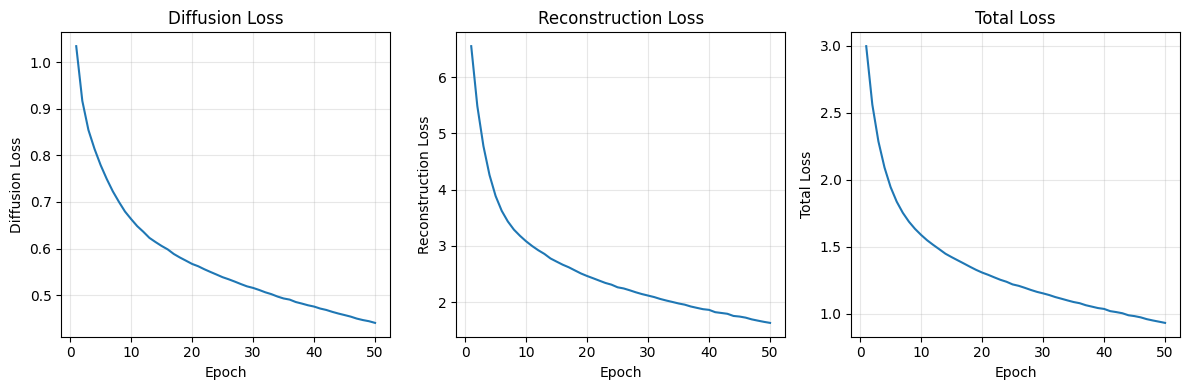

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(ngram_history['epoch'], ngram_history['diffusion_loss'])
plt.xlabel('Epoch')
plt.ylabel('Diffusion Loss')
plt.title('Diffusion Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(ngram_history['epoch'], ngram_history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(ngram_history['epoch'], ngram_history['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

I think we can still train further since the losses are continously reducing at a constant rate still. Let us take this moment to test our generation.

let us generate some sample lines to check our generation quality. We use the conditioning tokens to guide our diffusion model to denoise some lines as shown below. The number of denosiing steps can also be a useful parameter to see at what range our model is comfortable at denoising from.

In [ ]:
def generate_ngram(first_word, last_word, length=8, position='COMPLETE', num_steps=100):
    """Generate n-gram with structural conditioning"""
    diffusion_model.eval()

    # Map position labels → integer IDs for embedding lookup
    POS_MAP = {'START': 0, 'MIDDLE': 1, 'END': 2, 'COMPLETE': 3}

    with torch.no_grad():
        # Build 4-part conditioning vector
        len_emb = length_embeddings(torch.tensor(length).to(device))                  # target length
        pos_emb = position_embeddings(torch.tensor(POS_MAP[position]).to(device))    # structural position type
        first_emb = text_embeddings(torch.tensor(word2id.get(first_word, UNK_ID)).to(device))  # first-word embedding
        last_emb  = text_embeddings(torch.tensor(word2id.get(last_word,  UNK_ID)).to(device))  # last-word embedding

        # Stack into shape [1, 4, 768] for the model
        conditioning = torch.stack([len_emb, pos_emb, first_emb, last_emb]).unsqueeze(0)

        # Start diffusion from pure noise
        latent = torch.randn(1, 20, 768).to(device)

        # Setup DDIM inference steps
        inference_scheduler.set_timesteps(num_steps)

        # Denoising loop
        for t in inference_scheduler.timesteps:
            noise_pred = diffusion_model(latent, torch.tensor([t]).to(device), conditioning)
            latent = inference_scheduler.step(noise_pred, t, latent).prev_sample

        # Decode: project latent → vocabulary logits using weight tying
        logits = torch.matmul(latent, text_embeddings.weight.T)
        token_ids = logits.argmax(dim=-1)[0]

        # Convert IDs → words and strip padding/specials
        words = [
            id2word[idx.item()]
            for idx in token_ids
            if idx.item() in id2word and id2word[idx.item()] != '<PAD>'
        ]

        # Return exactly the requested n-gram length
        return ' '.join(words[:length])


In [26]:
# Test
print(generate_ngram('from', 'increase', 6, 'COMPLETE', 100))
print(generate_ngram('thy', 'heart', 7, 'START', 100))
print(generate_ngram('love', 'time', 8, 'MIDDLE', 100))

from insults lion's ruinate shook age
heart highmost except firstborn loan; pitch [144]
wasted firm dreading herd false-speaking millioned stormy withal


Not bad at all, we are finally generating sentences that adhere to our word count guidance. However, we dont seem to have a control over which word from the three words we provide gets added to the line. but the sentences look semamntically sound compared to our previous attempt. 

In [ ]:
# Generate same conditioning 3 times
for i in range(3):
    print(generate_ngram('from', 'increase', 6, 'COMPLETE'))


from sap tiger's pierced shook age
from ate shamefully tear shook age
from sap shamefully tear shook age


It usually seems to fallback on repetition with a few minor modifications

In [28]:
print(generate_ngram('thy', 'love', 8, 'START'))
print(generate_ngram('when', 'beauty', 8, 'MIDDLE'))  
print(generate_ngram('but', 'death', 8, 'END'))

hate's until except loan; loan; be; mind: until
beauty trophies steep-up sharp'st firstborn speed: unrespected; until
hied dancing chips deeds; composition grievances long-lived over


let us add a cleaning utility which replaces any special characters denoised and a sonnet generator that takes what our ngram generator did except expand it to a 14 line sonnet with proper formatting. We only input the prompt words and based on the structure of the sonnet to be produced, we add the remaining position and word count embeddings

In [ ]:
def clean_text(text):
    """Remove special characters and clean spacing"""
    # Replace special chars with comma
    text = text.replace('[', ',').replace(']', ',').replace('#', ',')
    text = text.replace('(', ',').replace(')', ',').replace('{', ',').replace('}', ',')
    
    # Fix multiple commas and spaces
    while ',,' in text:
        text = text.replace(',,', ',')
    while '  ' in text:
        text = text.replace('  ', ' ')
    
    # Clean edges
    text = text.strip(' ,.')
    
    # Capitalize first letter
    if text:
        text = text[0].upper() + text[1:]
    
    return text

def generate_sonnet(prompt_words, num_steps=100):
    """
    Generate 14-line Shakespearean sonnet.
    
    Args:
        prompt_words: list of 2-3 thematic words for the sonnet
        num_steps: DDIM denoising steps
    
    Returns:
        Formatted sonnet string
    """
    diffusion_model.eval()
    
    # Extract prompt word IDs
    prompt_ids = [word2id.get(w.lower(), UNK_ID) for w in prompt_words[:3]]
    while len(prompt_ids) < 3:
        prompt_ids.append(UNK_ID)
    
    # Generate 14 lines with appropriate positions
    lines = []
    
    for line_idx in range(14):
        with torch.no_grad():
            # Determine position based on line number
            if line_idx == 0:
                position = 0  # START of sonnet
                length = 8
                first_id = prompt_ids[0]
                last_id = prompt_ids[1]
            elif line_idx == 13:
                position = 2  # END of sonnet
                length = 8
                first_id = prompt_ids[2]
                last_id = prompt_ids[0]
            elif line_idx in [3, 7, 11]:
                position = 2  # END of quatrain
                length = 8
                # Use prompt words in rotation
                first_id = prompt_ids[line_idx % 3]
                last_id = prompt_ids[(line_idx + 1) % 3]
            else:
                position = 1  # MIDDLE of quatrain
                length = 8
                first_id = prompt_ids[line_idx % 3]
                last_id = prompt_ids[(line_idx + 2) % 3]
            
            # Build conditioning
            len_emb = length_embeddings(torch.tensor(length).to(device))
            pos_emb = position_embeddings(torch.tensor(position).to(device))
            first_emb = text_embeddings(torch.tensor(first_id).to(device))
            last_emb = text_embeddings(torch.tensor(last_id).to(device))
            
            conditioning = torch.stack([len_emb, pos_emb, first_emb, last_emb]).unsqueeze(0)
            
            # Generate
            latent = torch.randn(1, 20, 768).to(device)
            inference_scheduler.set_timesteps(num_steps)
            
            for t in inference_scheduler.timesteps:
                noise_pred = diffusion_model(latent, torch.tensor([t]).to(device), conditioning)
                latent = inference_scheduler.step(noise_pred, t, latent).prev_sample
            
            # Decode
            logits = torch.matmul(latent, text_embeddings.weight.T)
            token_ids = logits.argmax(dim=-1)[0]
            
            words = [id2word[idx.item()] for idx in token_ids if idx.item() in id2word and id2word[idx.item()] != '<PAD>']
            line_text = ' '.join(words[:length])
            line_text = clean_text(line_text)
            
            lines.append(line_text)
    
    # Format sonnet with quatrain breaks
    formatted = []
    for i, line in enumerate(lines):
        formatted.append(line)
        if i in [3, 7, 11]:
            formatted.append('')
    
    return '\n'.join(formatted)




In [30]:
sonnet = generate_sonnet(['love', 'time', 'beauty'], num_steps=100)
print(sonnet)

Time sunset accidents proceed elsewhere; life's outbraves dwell;
Wasted millioned praise; store; false-speaking prefiguring; stormy withal
The lords abide; surly firstborn prefiguring; least; withal
Steep-up millioned "kind part: withal part: quill exchanged

Wasted firm praise; herd twofold sing; stormy withal
Such lords dreading surly firstborn speed: white; withal
Niggard sharp'st charged; sharp'st beated mind: ye: outbraves
Beautiful wrackful steep-up lay; withal zealous quill withal

The lords dreading surly firstborn prefiguring; unrespected; withal
Niggard sharp'st charged; sharp'st beated speed: true: outbraves
Wasted firm praise; surly twofold sing; stormy exchanged
At sharp'st steep-up lay; touched zealous quill outbraves

Together intents charged; sharp'st firstborn lay; white; miscalled
Precious owner's ! dross; composition grievances quill withal


let us test at a higher number of denoising steps

In [31]:
sonnet = generate_sonnet(['love', 'time', 'beauty'], num_steps=300)
print(sonnet)

Time lion's accidents proceed loan; life's will; outbraves
Wasted firm ye: will; twofold sing; stormy withal
The lords dreading surly firstborn prefiguring; least; withal
Steep-up blow ye: store; withal mind: spoils withal

Wasted firm praise; surly false-speaking distance stormy withal
The lords bevel; surly firstborn speed: least; withal
Wisdom center steep-up sharp'st beated prefiguring; unrespected; tan
Precious wights steep-up lay; withal prefiguring; quill withal

The lords dreading 'cide firstborn prefiguring; white; withal
Present'st sharp'st charged; dross; beated prefiguring; unrespected; outbraves
Wasted firm praise; surly false-speaking prefiguring; stormy withal
Beautiful life's store; subsist; deeds; life's quill outbraves

Niggard dust steep-up sharp'st tan sing; unrespected; miscalled
At sharp'st be; lay; touched grievances apple outbraves


there is some repetition for some tokens but we beleive the lower number of steps produced a better diversity of words

let us train for another 100 epochs, we weight the reconstruction loss by 0.5 so we force our model to focus on the reconstruction task more than diffusion.

In [32]:
for epoch in range(50, 150):
    epoch_diff = 0
    epoch_recon = 0
    
    for batch in tqdm(ngram_loader, desc=f"Epoch {epoch+1}/150"):
        token_ids = batch['token_ids'].to(device)
        conditioning = batch['conditioning'].to(device)
        
        clean_embeddings = text_embeddings(token_ids)
        timesteps = torch.randint(0, 1000, (clean_embeddings.shape[0],)).to(device)
        noise = torch.randn_like(clean_embeddings)
        noisy_embeddings = train_scheduler.add_noise(clean_embeddings, noise, timesteps)
        
        predicted_noise = diffusion_model(noisy_embeddings, timesteps, conditioning)
        diffusion_loss = F.mse_loss(predicted_noise, noise)
        
        alpha_prod = train_scheduler.alphas_cumprod[timesteps].view(-1, 1, 1)
        denoised = (noisy_embeddings - torch.sqrt(1 - alpha_prod) * predicted_noise) / torch.sqrt(alpha_prod)
        denoised = torch.clamp(denoised, -3, 3)
        
        logits = torch.matmul(denoised, text_embeddings.weight.T)
        reconstruction_loss = F.cross_entropy(logits.reshape(-1, vocab_size), token_ids.reshape(-1), ignore_index=PAD_ID)
        
        total_loss = diffusion_loss + 0.5 * reconstruction_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(text_embeddings.parameters()) + list(length_embeddings.parameters()) + 
            list(position_embeddings.parameters()) + list(diffusion_model.parameters()), max_norm=1.0
        )
        optimizer.step()
        scheduler.step()
        
        epoch_diff += diffusion_loss.item()
        epoch_recon += reconstruction_loss.item()
    
    avg_diff = epoch_diff / len(ngram_loader)
    avg_recon = epoch_recon / len(ngram_loader)
    
    ngram_history['epoch'].append(epoch + 1)
    ngram_history['diffusion_loss'].append(avg_diff)
    ngram_history['reconstruction_loss'].append(avg_recon)
    ngram_history['total_loss'].append(avg_diff + 0.5 * avg_recon)
    
    print(f"Epoch {epoch+1}: Diff={avg_diff:.4f} Recon={avg_recon:.4f}")

Epoch 51/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 51: Diff=0.4707 Recon=1.4701


Epoch 52/150: 100%|██████████| 1889/1889 [04:33<00:00,  6.90it/s]


Epoch 52: Diff=0.4761 Recon=1.4346


Epoch 53/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.10it/s]


Epoch 53: Diff=0.4790 Recon=1.4049


Epoch 54/150: 100%|██████████| 1889/1889 [04:16<00:00,  7.37it/s]


Epoch 54: Diff=0.4802 Recon=1.3841


Epoch 55/150: 100%|██████████| 1889/1889 [04:32<00:00,  6.92it/s]


Epoch 55: Diff=0.4788 Recon=1.3611


Epoch 56/150: 100%|██████████| 1889/1889 [04:22<00:00,  7.19it/s]


Epoch 56: Diff=0.4800 Recon=1.3375


Epoch 57/150: 100%|██████████| 1889/1889 [04:25<00:00,  7.12it/s]


Epoch 57: Diff=0.4768 Recon=1.3046


Epoch 58/150: 100%|██████████| 1889/1889 [04:29<00:00,  7.01it/s]


Epoch 58: Diff=0.4730 Recon=1.2832


Epoch 59/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.03it/s]


Epoch 59: Diff=0.4733 Recon=1.2638


Epoch 60/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 60: Diff=0.4711 Recon=1.2400


Epoch 61/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 61: Diff=0.4685 Recon=1.2160


Epoch 62/150: 100%|██████████| 1889/1889 [04:22<00:00,  7.19it/s]


Epoch 62: Diff=0.4663 Recon=1.1964


Epoch 63/150: 100%|██████████| 1889/1889 [04:20<00:00,  7.26it/s]


Epoch 63: Diff=0.4633 Recon=1.1694


Epoch 64/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.08it/s]


Epoch 64: Diff=0.4622 Recon=1.1597


Epoch 65/150: 100%|██████████| 1889/1889 [04:27<00:00,  7.07it/s]


Epoch 65: Diff=0.4593 Recon=1.1368


Epoch 66/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.08it/s]


Epoch 66: Diff=0.4566 Recon=1.1124


Epoch 67/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 67: Diff=0.4547 Recon=1.0926


Epoch 68/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.09it/s]


Epoch 68: Diff=0.4518 Recon=1.0774


Epoch 69/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.09it/s]


Epoch 69: Diff=0.4490 Recon=1.0602


Epoch 70/150: 100%|██████████| 1889/1889 [04:25<00:00,  7.10it/s]


Epoch 70: Diff=0.4473 Recon=1.0318


Epoch 71/150: 100%|██████████| 1889/1889 [04:29<00:00,  7.01it/s]


Epoch 71: Diff=0.4452 Recon=1.0221


Epoch 72/150: 100%|██████████| 1889/1889 [04:29<00:00,  7.02it/s]


Epoch 72: Diff=0.4421 Recon=1.0041


Epoch 73/150: 100%|██████████| 1889/1889 [04:28<00:00,  7.04it/s]


Epoch 73: Diff=0.4391 Recon=0.9882


Epoch 74/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.13it/s]


Epoch 74: Diff=0.4381 Recon=0.9726


Epoch 75/150: 100%|██████████| 1889/1889 [04:26<00:00,  7.10it/s]


Epoch 75: Diff=0.4359 Recon=0.9536


Epoch 76/150: 100%|██████████| 1889/1889 [04:34<00:00,  6.88it/s]


Epoch 76: Diff=0.4321 Recon=0.9353


Epoch 77/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 77: Diff=0.4311 Recon=0.9232


Epoch 78/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 78: Diff=0.4321 Recon=0.9185


Epoch 79/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 79: Diff=0.4279 Recon=0.8946


Epoch 80/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 80: Diff=0.4265 Recon=0.8817


Epoch 81/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 81: Diff=0.4259 Recon=0.8720


Epoch 82/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 82: Diff=0.4218 Recon=0.8609


Epoch 83/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 83: Diff=0.4216 Recon=0.8438


Epoch 84/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 84: Diff=0.4205 Recon=0.8324


Epoch 85/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 85: Diff=0.4204 Recon=0.8276


Epoch 86/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 86: Diff=0.4186 Recon=0.8275


Epoch 87/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 87: Diff=0.4187 Recon=0.8157


Epoch 88/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 88: Diff=0.4165 Recon=0.8068


Epoch 89/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 89: Diff=0.4162 Recon=0.7961


Epoch 90/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 90: Diff=0.4148 Recon=0.7998


Epoch 91/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 91: Diff=0.4145 Recon=0.7909


Epoch 92/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 92: Diff=0.4135 Recon=0.7803


Epoch 93/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 93: Diff=0.4138 Recon=0.7847


Epoch 94/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 94: Diff=0.4131 Recon=0.7713


Epoch 95/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 95: Diff=0.4124 Recon=0.7728


Epoch 96/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 96: Diff=0.4127 Recon=0.7714


Epoch 97/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 97: Diff=0.4130 Recon=0.7697


Epoch 98/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 98: Diff=0.4121 Recon=0.7694


Epoch 99/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 99: Diff=0.4106 Recon=0.7645


Epoch 100/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 100: Diff=0.4117 Recon=0.7658


Epoch 101/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 101: Diff=0.4102 Recon=0.7606


Epoch 102/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 102: Diff=0.4104 Recon=0.7625


Epoch 103/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 103: Diff=0.4101 Recon=0.7567


Epoch 104/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 104: Diff=0.4099 Recon=0.7599


Epoch 105/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 105: Diff=0.4104 Recon=0.7550


Epoch 106/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 106: Diff=0.4107 Recon=0.7569


Epoch 107/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 107: Diff=0.4098 Recon=0.7552


Epoch 108/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 108: Diff=0.4094 Recon=0.7513


Epoch 109/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 109: Diff=0.4094 Recon=0.7533


Epoch 110/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 110: Diff=0.4094 Recon=0.7578


Epoch 111/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 111: Diff=0.4094 Recon=0.7544


Epoch 112/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 112: Diff=0.4084 Recon=0.7521


Epoch 113/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 113: Diff=0.4087 Recon=0.7502


Epoch 114/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 114: Diff=0.4075 Recon=0.7518


Epoch 115/150: 100%|██████████| 1889/1889 [04:22<00:00,  7.18it/s]


Epoch 115: Diff=0.4069 Recon=0.7516


Epoch 116/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 116: Diff=0.4070 Recon=0.7629


Epoch 117/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 117: Diff=0.4070 Recon=0.7513


Epoch 118/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 118: Diff=0.4066 Recon=0.7518


Epoch 119/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 119: Diff=0.4067 Recon=0.7551


Epoch 120/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 120: Diff=0.4052 Recon=0.7575


Epoch 121/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 121: Diff=0.4051 Recon=0.7610


Epoch 122/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 122: Diff=0.4054 Recon=0.7671


Epoch 123/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 123: Diff=0.4042 Recon=0.7581


Epoch 124/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 124: Diff=0.4063 Recon=0.7634


Epoch 125/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.15it/s]


Epoch 125: Diff=0.4039 Recon=0.7598


Epoch 126/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 126: Diff=0.4055 Recon=0.7687


Epoch 127/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 127: Diff=0.4063 Recon=0.7679


Epoch 128/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 128: Diff=0.4060 Recon=0.7705


Epoch 129/150: 100%|██████████| 1889/1889 [04:24<00:00,  7.16it/s]


Epoch 129: Diff=0.4063 Recon=0.7720


Epoch 130/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 130: Diff=0.4081 Recon=0.7777


Epoch 131/150: 100%|██████████| 1889/1889 [04:22<00:00,  7.18it/s]


Epoch 131: Diff=0.4074 Recon=0.7744


Epoch 132/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 132: Diff=0.4089 Recon=0.7793


Epoch 133/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 133: Diff=0.4091 Recon=0.7796


Epoch 134/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 134: Diff=0.4112 Recon=0.7829


Epoch 135/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 135: Diff=0.4123 Recon=0.7823


Epoch 136/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 136: Diff=0.4156 Recon=0.7944


Epoch 137/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 137: Diff=0.4154 Recon=0.7909


Epoch 138/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 138: Diff=0.4171 Recon=0.7914


Epoch 139/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 139: Diff=0.4199 Recon=0.8045


Epoch 140/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 140: Diff=0.4233 Recon=0.8123


Epoch 141/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 141: Diff=0.4249 Recon=0.8087


Epoch 142/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 142: Diff=0.4266 Recon=0.8184


Epoch 143/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 143: Diff=0.4308 Recon=0.8135


Epoch 144/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 144: Diff=0.4327 Recon=0.8262


Epoch 145/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 145: Diff=0.4346 Recon=0.8336


Epoch 146/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]


Epoch 146: Diff=0.4383 Recon=0.8296


Epoch 147/150: 100%|██████████| 1889/1889 [04:22<00:00,  7.19it/s]


Epoch 147: Diff=0.4424 Recon=0.8385


Epoch 148/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.17it/s]


Epoch 148: Diff=0.4453 Recon=0.8484


Epoch 149/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.18it/s]


Epoch 149: Diff=0.4501 Recon=0.8496


Epoch 150/150: 100%|██████████| 1889/1889 [04:23<00:00,  7.16it/s]

Epoch 150: Diff=0.4508 Recon=0.8562


In [33]:
torch.save({
    'text_embeddings': text_embeddings.state_dict(),
    'length_embeddings': length_embeddings.state_dict(),
    'position_embeddings': position_embeddings.state_dict(),
    'diffusion_model': diffusion_model.state_dict(),
    'vocab': {'word2id': word2id, 'id2word': id2word},
    'history': ngram_history
}, 'ngram_model_epoch150.pt')

**let us plot our progress**

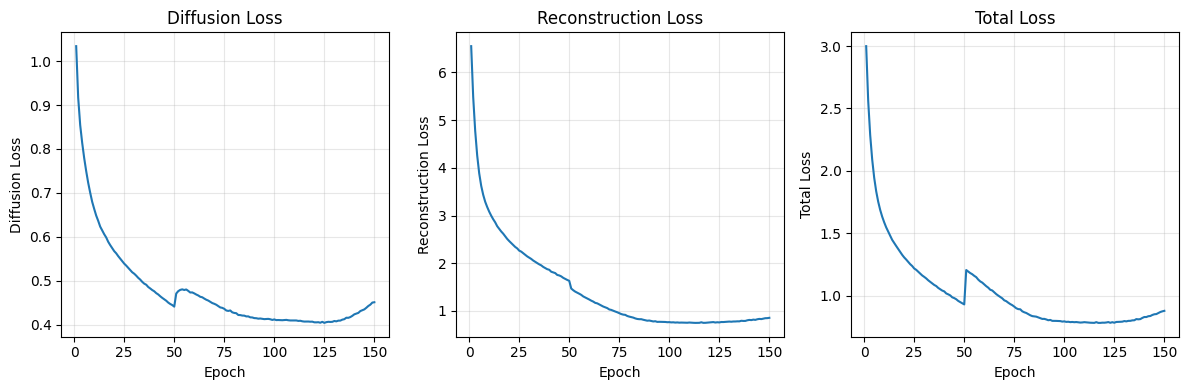

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(ngram_history['epoch'], ngram_history['diffusion_loss'])
plt.xlabel('Epoch')
plt.ylabel('Diffusion Loss')
plt.title('Diffusion Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(ngram_history['epoch'], ngram_history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(ngram_history['epoch'], ngram_history['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

we see a sharp rise in diffusion loss and a sudden blip in reconstruction loss at the moment where we increased reconstruction loss weights. We seem to have plateaued and even gained some of the loss back

In [35]:
sonnet = generate_sonnet(['love', 'time', 'beauty'], num_steps=100)
print(sonnet)

Buried acceptable remove elder captive junes familiar lying
Thou best though dressing wood candles privilege; unswayed
Thou felt at dressing chaste familiar increase; but
Delayed dial's composition bitter o'ersways life's neck redeem

My best must dressing wood fire--my privilege; unswayed
Thou felt at dressing affable familiar ruminate but
To forests height hied busy fleece speed: hied
The delayed distempered credit torture smiling gazing redeem

Thou felt at dressing affable familiar ruminate but
To forests user dressing busy fleece truest hied
My best must dressing wood candles privilege; unswayed
Her little offenses burdens age's life's hated hied

The forests feathered dressing busy fleece truest hied
The little offenses outbraves wretch's life's remove hied


The model was more creative at 50 epochs, let us test at lower denoising steps

In [36]:
sonnet = generate_sonnet(['love', 'hate', 'killed'], num_steps=50)
print(sonnet)

Love resty favorites thy hate's new-appearing life's shamefully
Hate farewell receives guest hammered candles candles shamefully
She quenched no acquainted older favor thrice harvest
Delayed pitied endowed delayed water urge variation or

Hate although receives guest hammered fire--my candles dreading
You quenched no guest older favor thrice pleasant
My weakness might touch sad thunder spring; selfsame
Said grant despised forbear o'ersways stand inherit your

She hated no flow older favor thrice selfsame
My weakness making touch drooping thunder spring; selfsame
Hate farewell receives report hammered candles rudely shamefully
Sorry sour making wail an strange dreading league

My weakness might touch sins thunder spring; selfsame
Sorry sour delayed despised an transgression dreading clean


much better, i believe our model even though upon random sampling of time steps, has learned to denoise well from a lower number. let us try 300

In [37]:
sonnet = generate_sonnet(['hell', 'time', 'love'], num_steps=300)
print(sonnet)

The sad enforced at torture fierce riches composition
Hell adieu than captive autumn sacred seal dearer;
My best making dressing wood candles ground; unswayed
Be counterfeit to another's changing counterfeit tract redeem

Time sad to pardon anger sacred thrice answered
My best though dressing wood candles ." unswayed
Delayed mounted at hap dart swift seal infant's
Delayed millioned answered bitter o'ersways life's neck redeem

My best making under wood candles ." unswayed
Delayed mounted lying hap dart swift seal busy
To adieu than pardon anger sacred stamped mounted
Delayed delayed mounted hap in amiss seal wherein

Another's mounted lying pardon dart swift seal busy
Delayed elder composition thrivers from amiss seal infant's


Testing at 150

In [39]:
sonnet = generate_sonnet(['heaven', 'hell', 'time'], num_steps=150)
print(sonnet)

Men beauty's taker sap get powerful riches buriest
To straight besmeared indirectly crown height thrice me
Time sad than hied anger together seal busy
To straight fleece woman's present'st counterfeit awards hell

By straight besmeared indirectly fore-bemoaned sad thrice muse
Time sad than pardon anger uneared thrice mounted
Heaven oppression than surly present'st vassal love-kindling holds
Old grow from quickly changing counterfeit grounded matter;

Time adieu though pardon anger sacred thrice mounted
Heaven oppression than surly present'st grievances love-kindling blesses
My straight besmeared indirectly yellow powerful rarities shop
To badness eyelids grievances pure threefold weakness holds

Heaven oppression than war's present'st vassal love-kindling blesses
To drooping composition grievances pure threefold lameness holds


Certain sentences are the same, even after different steps 

In [40]:
checkpoint = torch.load('ngram_model_epoch50.pt')

text_embeddings.load_state_dict(checkpoint['text_embeddings'])
length_embeddings.load_state_dict(checkpoint['length_embeddings'])
position_embeddings.load_state_dict(checkpoint['position_embeddings'])
diffusion_model.load_state_dict(checkpoint['diffusion_model'])


<All keys matched successfully>

In [43]:
sonnet = generate_sonnet(['love', 'hell', 'time'], num_steps=120)
print(sonnet)

Hell present'st bath wombs inherit stern hill hell
Another's bail age's bell inherit sharp'st withal hell
Time lords seething surly lily's sharp'st withal hell
Death's life's pilgrimage aloft inherit zealous correction hell

Ghastly follows age's bell flatterer surly withal flown
Time firm waiting surly lily's surly withal hell
Wasted firm praise; store; withal prefiguring; stormy withal
Death's lords dreading herd intend zealous correction hell

Leads lords at surly autumn surly withal hell
Wasted decease "had herd false-speaking sing; stormy exchanged
Firm firm age's bell inherit zealous withal hell
Lion's ambush ye: mind: withal mind: quill withal

Wasted firm dreading store; false-speaking millioned stormy exchanged
Lion's millioned "had part: discontent mind: quill withal


testing empty token prompts

In [44]:
sonnet = generate_sonnet([' ', ' ', ' '], num_steps=120)
print(sonnet)

Offender's harsh moan imitate speed: gate; fly forests
Forests until silver found: mind: sing; life's forests
Forests until treason crooked intents harsh fly forests
Alas until treason life's composition gate; zealous forests

Forests until treason crooked crossed sing; life's forests
Forests until rents store; excellent sing; life's fly
Forests until silver store; devil gate; life's forests
Forests until treason store; composition gate; zealous sadly

Forests until rents store; until sing; life's forests
Forests until rents crooked crossed inherit life's forests
Forests until blush crooked life's vial; life's sadly
Glorious until treason store; composition lips' eisel present'st

Forests until rents store; life's gate; recured forests
Forests until treason store; composition gate; dearths forests


lots of repitition, this is probably because, without the conditioning embedding for a start and an end word, the modal cheats to an easier more probable solution made of redundant tokens

In [45]:
checkpoint = torch.load('ngram_model_epoch150.pt')

text_embeddings.load_state_dict(checkpoint['text_embeddings'])
length_embeddings.load_state_dict(checkpoint['length_embeddings'])
position_embeddings.load_state_dict(checkpoint['position_embeddings'])
diffusion_model.load_state_dict(checkpoint['diffusion_model'])


<All keys matched successfully>

checking the same with 150 epoch model

In [ ]:
sonnet = generate_sonnet([' ', ' ', ' '], num_steps=120)
print(sonnet)

When termed head than task horse; spring; starved
She weakness once sing once taker thrice pleasant
She weakness once deserve once familiar thrice pleasant
Die dare once forbear making prefiguring; thrice hate's

She weakness once sing once taker thrice pleasant
She weakness once deserve once strangely thrice pleasant
She weakness once deserve once taker thrice pleasant
Die if faring forbear once statues thrice hate's

Have weakness once acquainted once taker thrice pleasant
She weakness once acquainted once taker thrice pleasant
She weakness once acquainted once taker thrice pleasant
Die though faring forbear once deface thrice hate's

Have weakness once sing once nine thrice pleasant
Die though faring forbear making deface thrice hate's


In [47]:
sonnet = generate_sonnet([' ', ' ', ' '], num_steps=500)
print(sonnet)

<UNK> termed head where task horse; spring; pleasant
Have weakness once sing once taker thrice pleasant
Have weakness once deserve once taker thrice pleasant
Die if once forbear making prefiguring; prove; hate's

Have weakness once sing once taker thrice pleasant
Have weakness once deserve once taker thrice pleasant
Have weakness once deserve once taker thrice pleasant
Die if once forbear making prefiguring; thrice hate's

Have weakness once acquainted once taker thrice pleasant
Have weakness once acquainted once taker thrice pleasant
Have weakness once acquainted once taker thrice pleasant
Die if once forbear making statues thrice hate's

Have weakness once sing once taker thrice pleasant
Die if once forbear making statues thrice hate's


In [48]:
sonnet = generate_sonnet([' ', 'high', ' '], num_steps=30)
print(sonnet)

Would termed woos than life's credit me to
<UNK> love-god mounted than never despised ah and
Better love-god never few he despised ah to
To neck than tattered burdens delayed owner's high

To trifle anything could he despised me my
Thou shoot red could wherefore bide not thy
She bark once duteous once strangely thrice harvest
Your hammered fierce tattered outbraves present'st false-speaking high

Have shoot wherefore should he bide not my
Have weakness once duteous once nine thrice reckoned
Have patience wherefore few he bide ah so
Now endowed faring married complexioned willingly thrice your

Have weakness once pass once nine thrice starved
Character though sad herald complexioned statues spring; and


This one above is a pretty good one 

# CONCLUSION

- semantic control is crucial as an embedding when dealing with diffusion on text task. the only way we can achieve coherence in grammar is through more number of samples and a good generalized pattern that can be modified by the model to accomodate for different sentence structures
- more data
- We still could have experimented with the model hyperparamaters apart from what was provided. Maybe tinkering with the number of channels and attention heads initialized could have provided better results.